![vki_logo](https://www.skywin.be/sites/default/files/logo-membres/vki_logo_blue_rectangular.jpg)
### MODULO: A package for Multiscale Proper Orthogonal Decomposition
#### Tutorial 1: POD and DMD of a simple test case

This first tutorial illustrate how to compute the Proper Orthogonal Decomposition (POD) and the Dynamic Mode Decomposition (DMD) of a simple dataset. This is the vortex shedding past a cylinder in a 2D simulations. The flow exhibit such a regular periodic behaviour that POD and DMD are barely distiguishable.

For an overview of the theory of these decompositions, see Chapters 6, 7 and 8 in the book [Mendez et al, 2022](https://www.cambridge.org/core/books/datadriven-fluid-mechanics/0327A1A43F7C67EE88BB13743FD9DC8D).


The dataset contains the velocity component and the grid information in 4 txt files. Some key information: the cylinder has a diameter of 15mm, in an overly large domain of 300 x 600 mm. The simulations were carried out in Openfoam then exported in a regulard grid.
The dataset was produced by Denis Dumoulin in his STP at VKI (report available upon request).

The inlet velocity is 10m/s, with a TI of 5%. The sampling frequency in the data is Fs=100 Hz. It is important to note that the dataset contains NANs in the location of the cylinder. These can be safely ignored using numpy's nan_to_num, which replaces the Nans with zeros.



In [1]:
# note : it is assumed that you have modulo installed
# pip install modulo # otherwise python -m pip install -e . (use the jupyter notebook terminal)

#### Load packages and prepare plot customization (Optional)

In [1]:
import numpy as np # we use this to manipulate data 
import matplotlib.pyplot as plt # this is for plotting
import os  # this is to create/rename/delete folders
from modulo_vki import ModuloVKI # this is to create modulo objects

# this is for plotting/animation purposes
from modulo_vki.utils.others import Animation_2D_CFD_Cyl
from modulo_vki.utils.others import Plot_2D_CFD_Cyl

### Plot Customization (Optional )
fontsize = 16
plt.rc('text', usetex=True)      
plt.rc('font', family='serif')
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['axes.labelsize'] = fontsize
plt.rcParams['legend.fontsize'] = fontsize
plt.rcParams['font.size'] = fontsize


#### Download the dataset and store it into a local folder+ prepare folder for results

In [2]:
# Extract all the Zip Files
FOLDER='Tutorial_1_2D_Cylinder_CFD_POD_DMD'

# First we unzip the file 
# First we unzip the file (note that this is the 7th exercise in the old enumeration)
import urllib.request
print('Downloading Data for Tutorial 1...')
url = 'https://osf.io/emgv2/download'
urllib.request.urlretrieve(url, 'Ex_7_2D_CFD.zip')
print('Download Completed! I prepare data Folder')
# Unzip the file 
from zipfile import ZipFile
String='Ex_7_2D_CFD.zip'
zf = ZipFile(String,'r')
zf.extractall('./')
zf.close() 
os.rename('Ex_7_2D_Cylinder_CFD', FOLDER) # rename the data flolder to FOLDER
os.remove(String) # Delete the zip file with the data 
print('Data set unzipped and ready ! ')

##### Load the data and create snapshot matrix D


In [3]:
# Read one snapshot and plot it 
U=np.loadtxt(FOLDER + os.sep+ 'U_Cyl.txt')                              # U component
V=np.loadtxt(FOLDER + os.sep+ 'V_Cyl.txt')                              # V component
X=np.loadtxt(FOLDER + os.sep+ 'X_Cyl.txt')                            # X coordinates
Y=np.loadtxt(FOLDER + os.sep+ 'Y_Cyl.txt')                            # Y coordinates

# We rebuild the mesh
Xg,Yg=np.meshgrid(X,Y)
n_x=len(Y); n_y=len(X); nxny=n_x*n_y
n_s=2*nxny; n_t=np.shape(U)[1]

t=np.arange(0,n_t)*1/1000

# Crete the snapshot Matrix:
D = np.zeros((n_s, n_t))

for k in range(0, n_t):    
    D[:int(n_s/2), k] = U[:, k]
    D[int(n_s/2):, k] = V[:, k]

##### Plot one snapshot and make a gif

We use the functions Plot_2D_CFD_Cyl and Animation_2D_CFD_Cyl available in 'others'. This file collects various auxiliary functions for the tutorials, for example for plotting and/or creating animations. 

In [4]:
# We can plot/export one of the snapshot
Plot_2D_CFD_Cyl(Xg,Yg,U,V,k=11,
                Name=FOLDER+os.sep+'Snapshot_11_Test.png')

plt.show()
# And we can make an animation from snapshot 1 to 100 in steps of 1:
Name_GIF=FOLDER+os.sep+'Animation_TEST.gif'
Animation_2D_CFD_Cyl(Name_GIF,D,Xg,Yg,1,100,1)


/Users/lorenzoschena/Desktop/MODULO/.venv/lib/python3.12/site-packages/modulo_vki/utils/others.py:218: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((0,0),0.0075,fill=True,color='r',edgecolor='k',alpha=0.5)
/Users/lorenzoschena/Desktop/MODULO/.venv/lib/python3.12/site-packages/modulo_vki/utils/others.py:218: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((0,0),0.0075,fill=True,color='r',edgecolor='k',alpha=0.5)


Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image exported
Image expo

'Gif Created'

## Step 1 : Proper Orthogonal Decomposition

We compute the POD using the snapshot approach (i.e. computing first K) or using the randomized SVD approach (test both and compare results and computational cost! )


In [5]:
FOLDER_POD_RESULTS=FOLDER+os.sep+'POD_Results_Cylinder_CFD'
if not os.path.exists(FOLDER_POD_RESULTS):
    os.makedirs(FOLDER_POD_RESULTS)

In [6]:
# --- Initialize MODULO object
m = ModuloVKI(data=np.nan_to_num(D))
# Compute the POD using Sirovinch's method
Phi_POD, Psi_POD, Sigma_POD = m.compute_POD_K()

MODULO (MODal mULtiscale pOd) is a software developed at the von Karman Institute to perform data driven modal decomposition of numerical and experimental data. 

Modulo assumes you have a uniform grid. If not, please give the weights as parameters of MODULO!
Computing correlation matrix...

 Computing Temporal correlation matrix K ...

 Done.
Computing Temporal Basis...
diagonalizing K....
Done.
Computing Spatial Basis...
Computing Phi from D...
Done.


<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
/var/folders/yy/6s27989914q94sycbl2gz1v00000gn/T/ipykernel_480/3942231927.py:21: SyntaxWarning: invalid escape sequence '\s'
  ax.set_ylabel('$\sigma_{\mathcal{P}}$',fontsize=16)
/Users/lorenzoschena/Desktop/MODULO/.venv/lib/python3.12/site-packages/modulo_vki/utils/others.py:218: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((0,0),0.0075,fill=True,color='r',edgecolor='k',alpha=0.5)


Image exported
Tutorial_1_2D_Cylinder_CFD_POD_DMD/POD_Results_Cylinder_CFD/POD_Mode_PSI_0.png Saved
Image exported
Tutorial_1_2D_Cylinder_CFD_POD_DMD/POD_Results_Cylinder_CFD/POD_Mode_PSI_1.png Saved
Image exported
Tutorial_1_2D_Cylinder_CFD_POD_DMD/POD_Results_Cylinder_CFD/POD_Mode_PSI_2.png Saved
Image exported
Tutorial_1_2D_Cylinder_CFD_POD_DMD/POD_Results_Cylinder_CFD/POD_Mode_PSI_3.png Saved
Image exported
Tutorial_1_2D_Cylinder_CFD_POD_DMD/POD_Results_Cylinder_CFD/POD_Mode_PSI_4.png Saved
Image exported
Tutorial_1_2D_Cylinder_CFD_POD_DMD/POD_Results_Cylinder_CFD/POD_Mode_PSI_5.png Saved


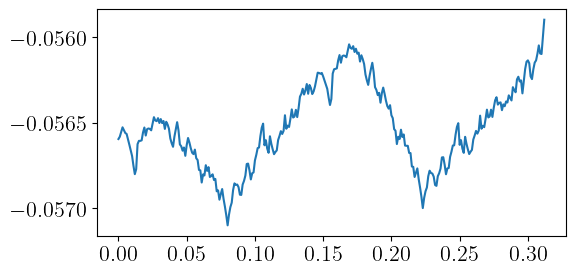

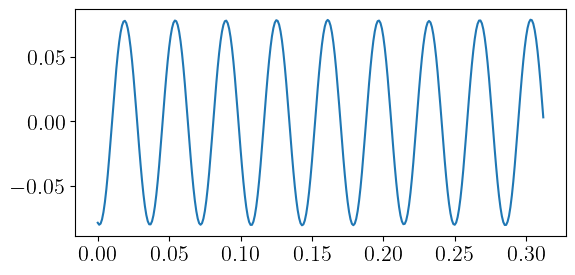

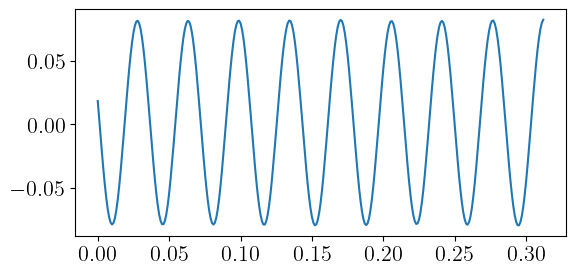

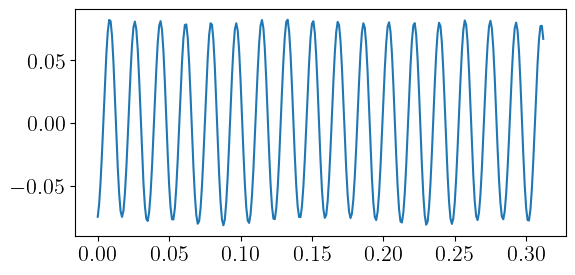

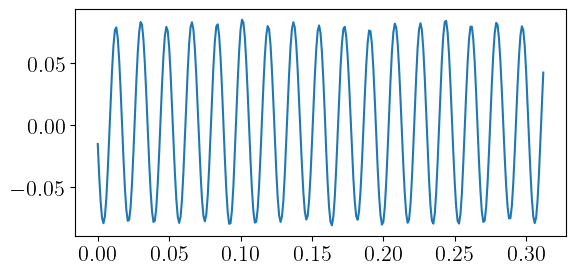

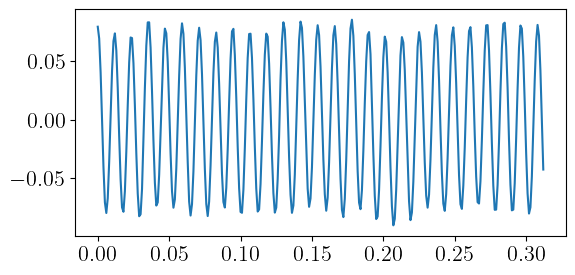

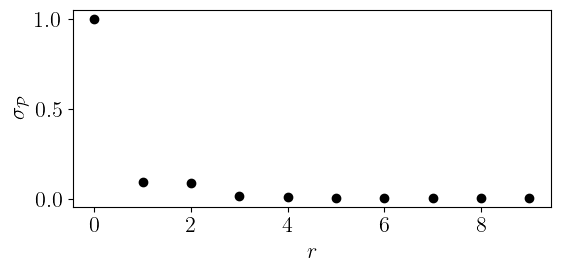

In [8]:
# We here plot the POD modes and their structures
U_D=Phi_POD[0:nxny,:]
V_D=Phi_POD[nxny::,:]

for K in range(6):
 Name=FOLDER_POD_RESULTS+os.sep+'POD_Mode_'+str(K)+'.png'
 #plt.title('$\Phi_{\mathcal{P}}(\mathbf{x}_i)$',fontsize=18)
 Plot_2D_CFD_Cyl(Xg,Yg,U_D,V_D,k=K,CL=0,Name=Name)
 #Then plot their temporal evolution
 fig, ax = plt.subplots(figsize=(6, 3)) # This creates the figure
 plt.plot(t,Psi_POD[:,K])
 plt.tight_layout(pad=1, w_pad=0.5, h_pad=1.0)
 Name=FOLDER_POD_RESULTS+os.sep+'POD_Mode_PSI_'+str(K)+'.png' 
 print(Name+' Saved')
 plt.savefig(Name, dpi=300) 

# Plot the sigma POD
fig, ax = plt.subplots(figsize=(6, 3)) # This creates the figure
plt.plot(Sigma_POD/Sigma_POD[0],'ko') 
ax.set_xlabel('$r$',fontsize=16)
ax.set_ylabel('$\sigma_{\mathcal{P}}$',fontsize=16)
plt.tight_layout()
Name=FOLDER_POD_RESULTS+os.sep+'Sigma_P.png'

plt.savefig(Name, dpi=300) 
plt.show()

Compare the spatial structures of the two decompositions! Remarkably, the POD is picking harmonic modes (even if no constraints enforced this, contrary to the DMD). Here is an approximation of the data using the leading 3 POD modes, followed by a script to animate the reconstruction. Compare this gif with the one build from the dataset. Do you see any appreciable difference ?

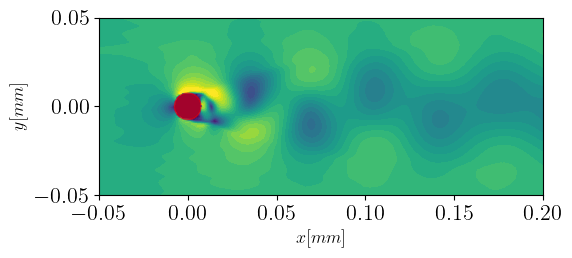

Image exported


<Figure size 640x480 with 0 Axes>

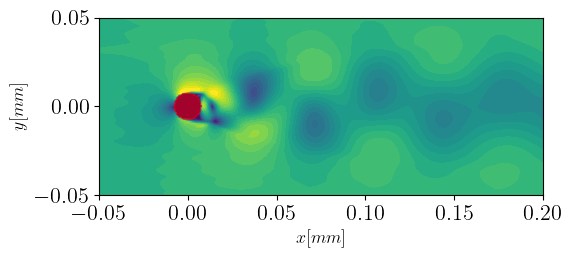

Image exported


<Figure size 640x480 with 0 Axes>

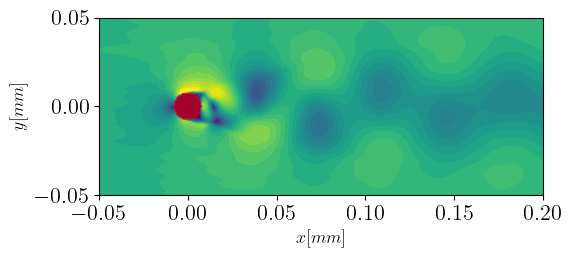

Image exported


<Figure size 640x480 with 0 Axes>

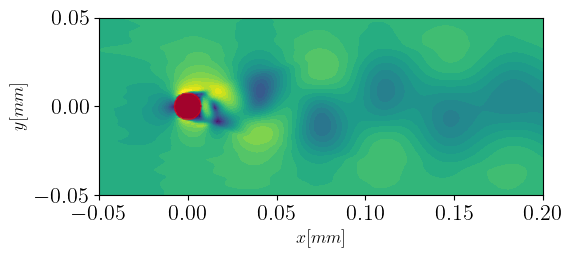

Image exported


<Figure size 640x480 with 0 Axes>

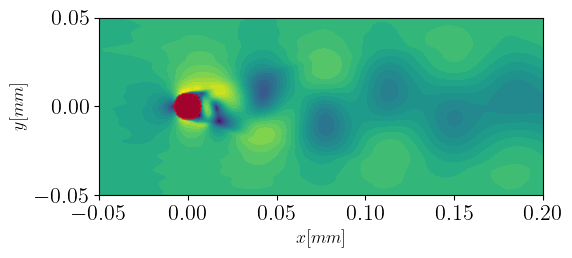

Image exported


<Figure size 640x480 with 0 Axes>

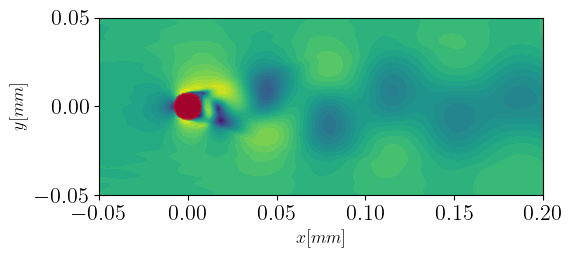

Image exported


<Figure size 640x480 with 0 Axes>

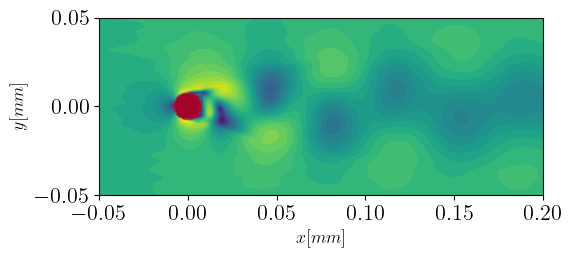

Image exported


<Figure size 640x480 with 0 Axes>

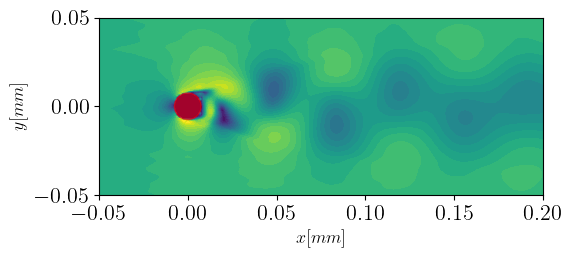

Image exported


<Figure size 640x480 with 0 Axes>

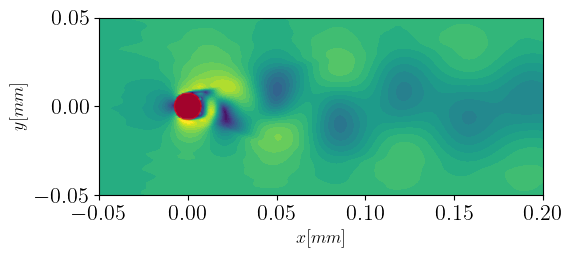

Image exported


<Figure size 640x480 with 0 Axes>

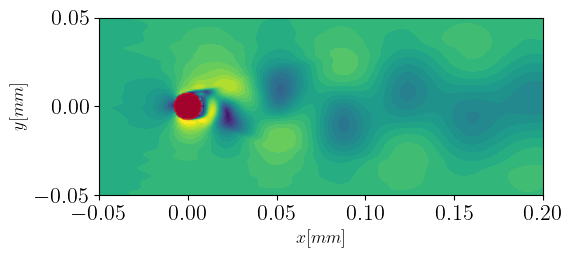

Image exported


<Figure size 640x480 with 0 Axes>

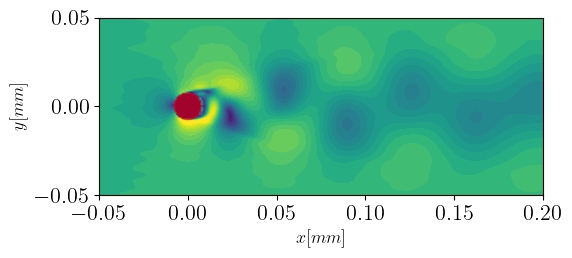

Image exported


<Figure size 640x480 with 0 Axes>

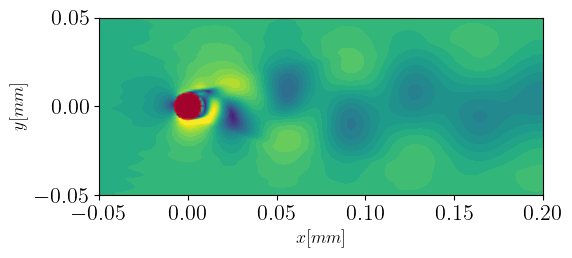

Image exported


<Figure size 640x480 with 0 Axes>

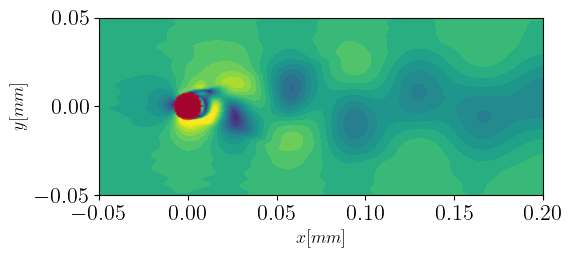

Image exported


<Figure size 640x480 with 0 Axes>

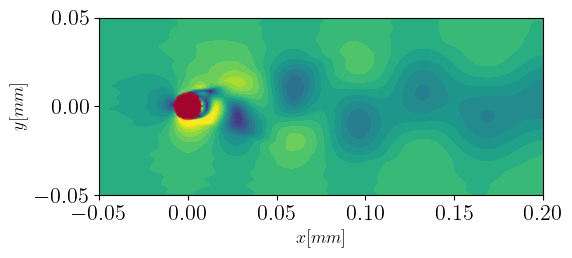

Image exported


<Figure size 640x480 with 0 Axes>

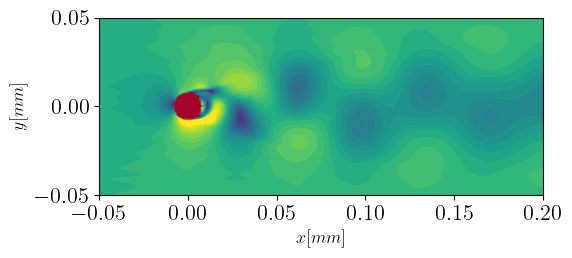

Image exported


<Figure size 640x480 with 0 Axes>

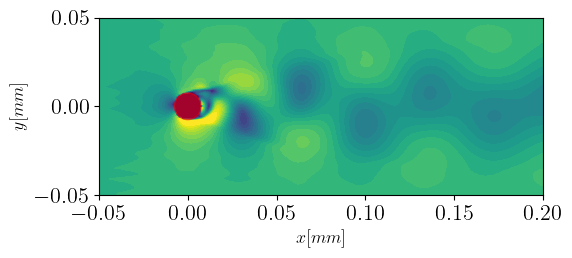

Image exported


<Figure size 640x480 with 0 Axes>

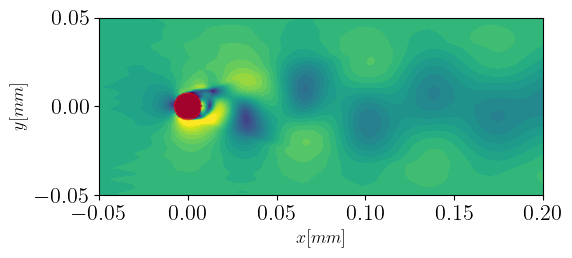

Image exported


<Figure size 640x480 with 0 Axes>

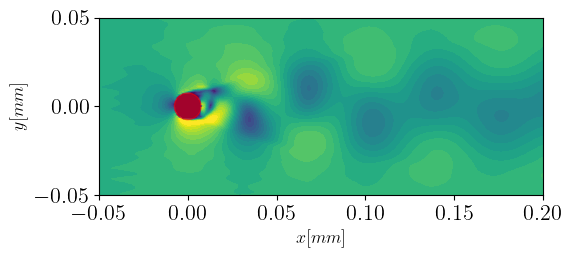

Image exported


<Figure size 640x480 with 0 Axes>

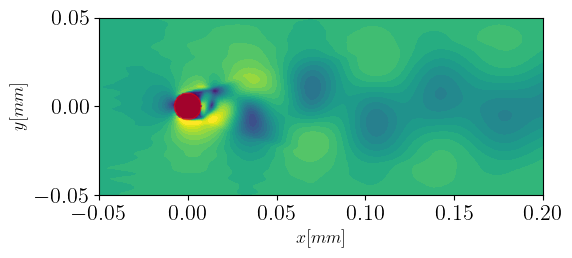

Image exported


<Figure size 640x480 with 0 Axes>

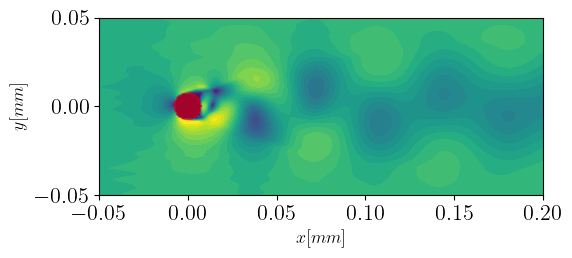

Image exported


<Figure size 640x480 with 0 Axes>

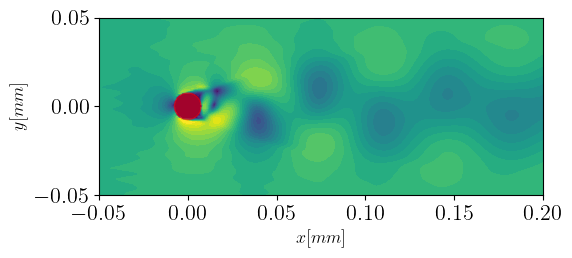

Image exported


<Figure size 640x480 with 0 Axes>

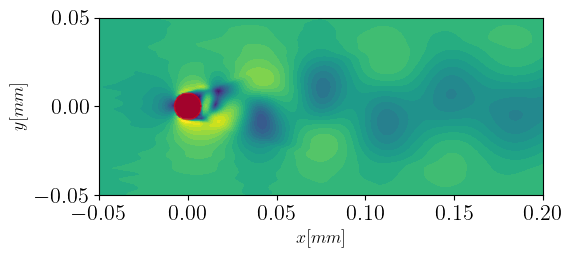

Image exported


<Figure size 640x480 with 0 Axes>

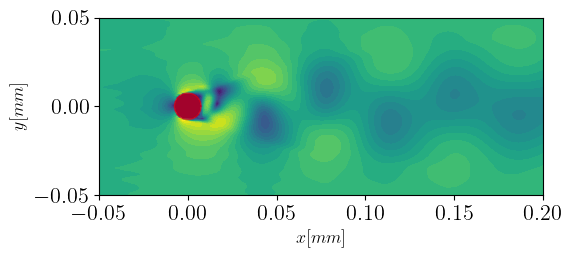

Image exported


<Figure size 640x480 with 0 Axes>

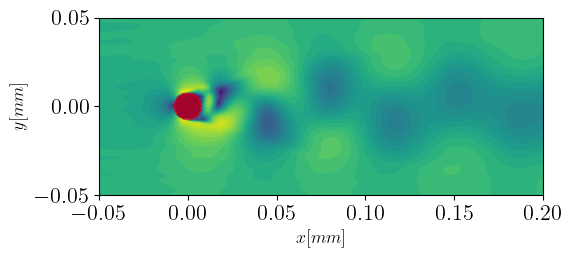

Image exported


<Figure size 640x480 with 0 Axes>

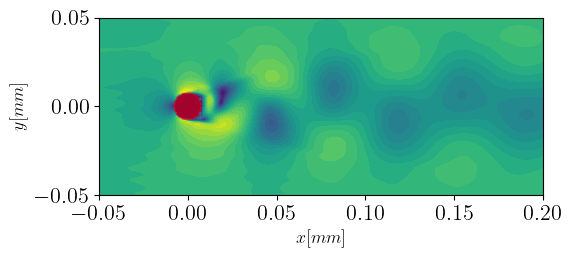

Image exported


<Figure size 640x480 with 0 Axes>

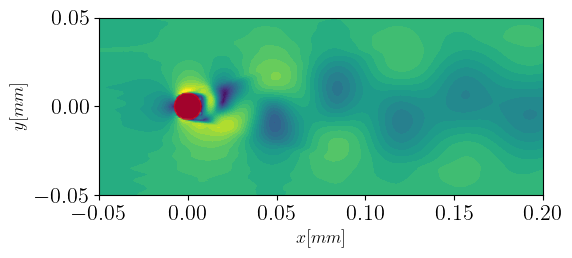

Image exported


<Figure size 640x480 with 0 Axes>

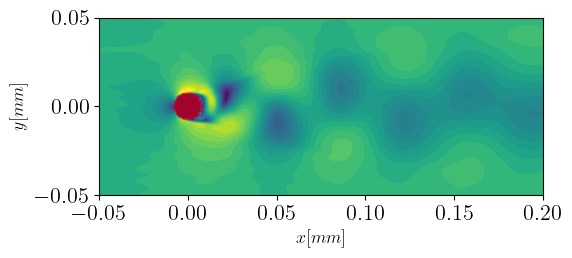

Image exported


<Figure size 640x480 with 0 Axes>

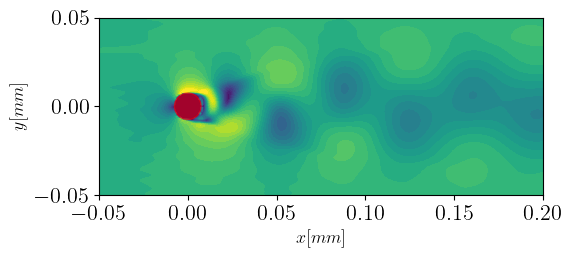

Image exported


<Figure size 640x480 with 0 Axes>

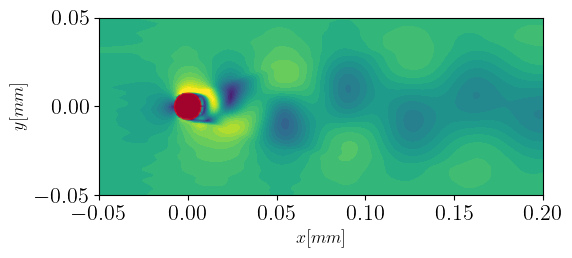

Image exported


<Figure size 640x480 with 0 Axes>

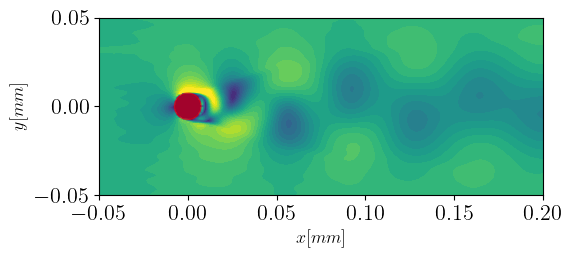

Image exported


<Figure size 640x480 with 0 Axes>

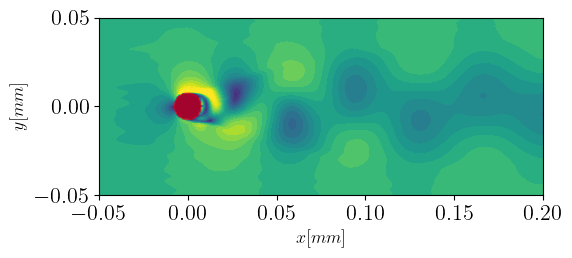

Image exported


<Figure size 640x480 with 0 Axes>

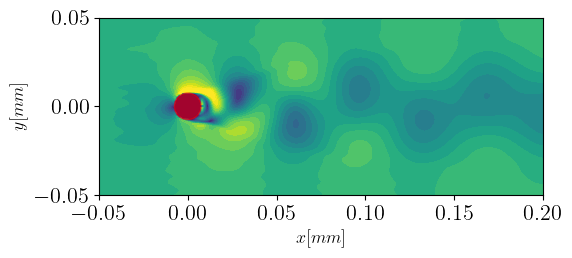

Image exported


<Figure size 640x480 with 0 Axes>

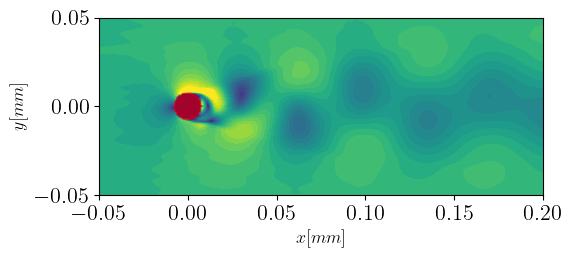

Image exported


<Figure size 640x480 with 0 Axes>

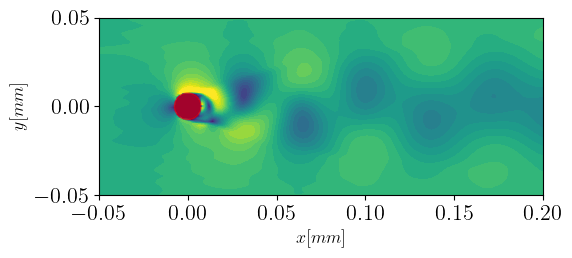

Image exported


<Figure size 640x480 with 0 Axes>

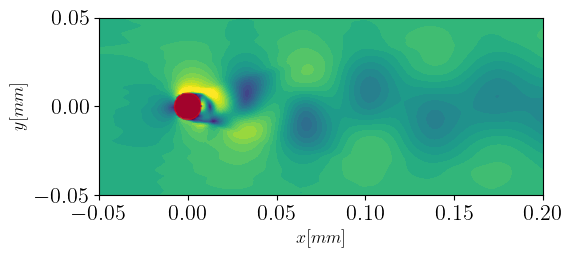

Image exported


<Figure size 640x480 with 0 Axes>

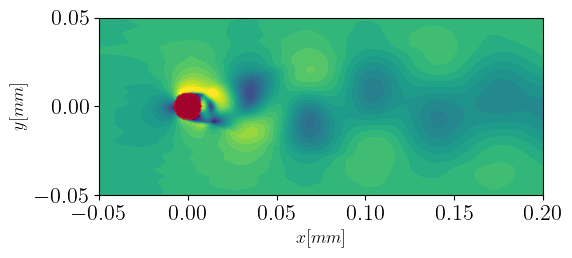

Image exported


<Figure size 640x480 with 0 Axes>

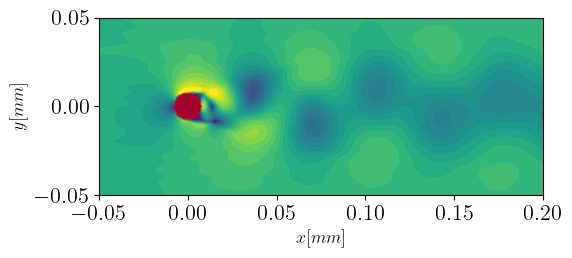

Image exported


<Figure size 640x480 with 0 Axes>

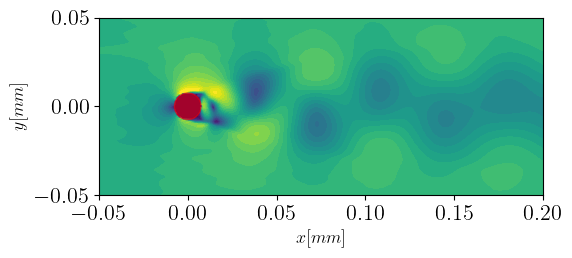

Image exported


<Figure size 640x480 with 0 Axes>

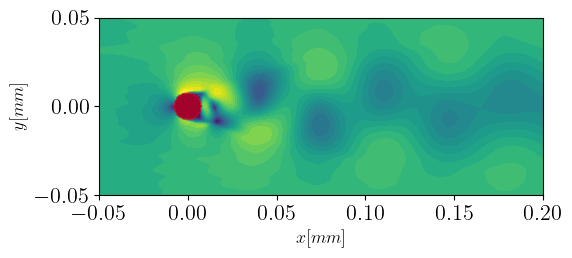

Image exported


<Figure size 640x480 with 0 Axes>

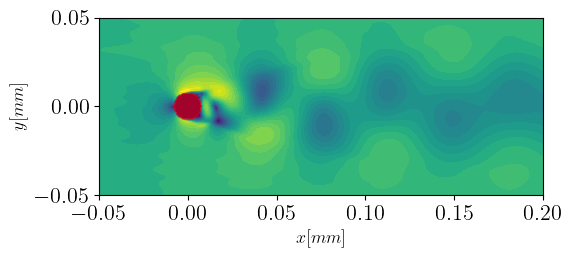

Image exported


<Figure size 640x480 with 0 Axes>

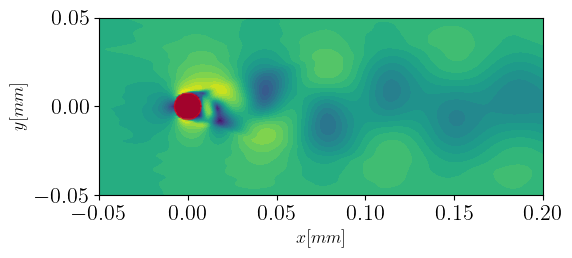

Image exported


<Figure size 640x480 with 0 Axes>

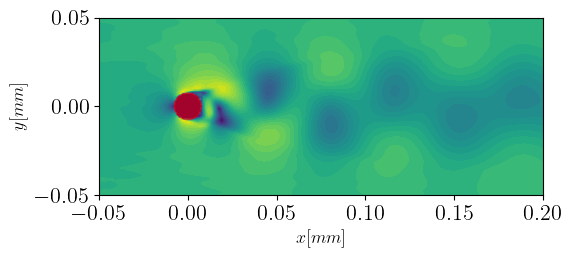

Image exported


<Figure size 640x480 with 0 Axes>

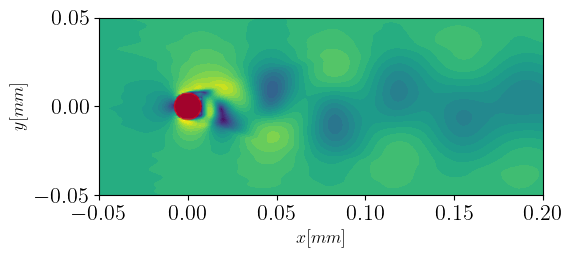

Image exported


<Figure size 640x480 with 0 Axes>

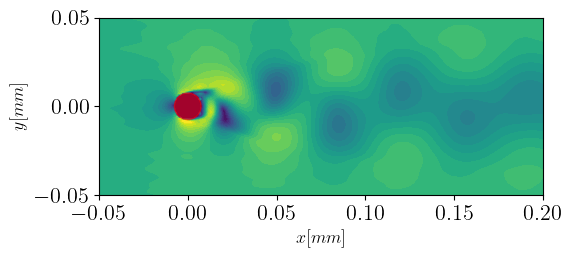

Image exported


<Figure size 640x480 with 0 Axes>

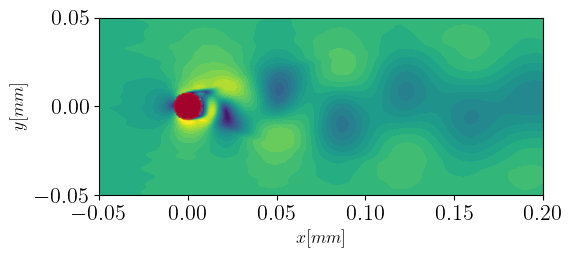

Image exported


<Figure size 640x480 with 0 Axes>

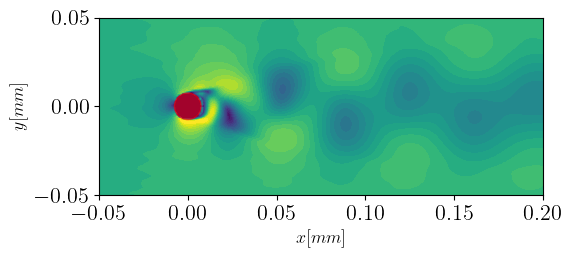

Image exported


<Figure size 640x480 with 0 Axes>

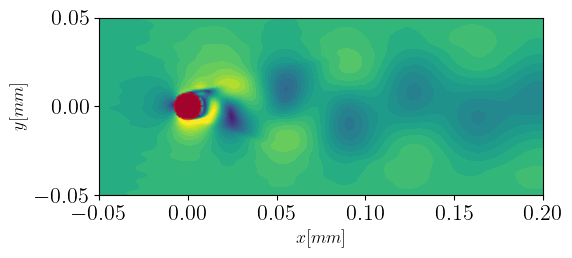

Image exported


<Figure size 640x480 with 0 Axes>

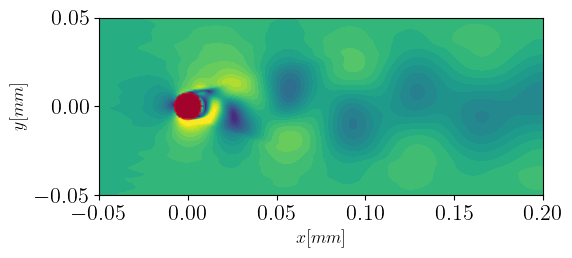

Image exported


<Figure size 640x480 with 0 Axes>

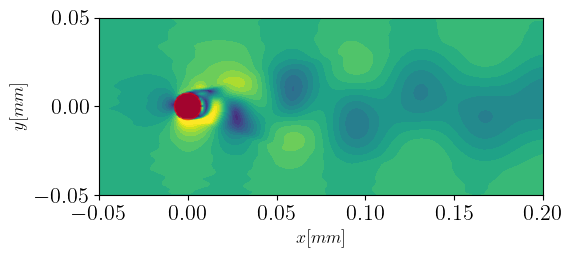

Image exported


<Figure size 640x480 with 0 Axes>

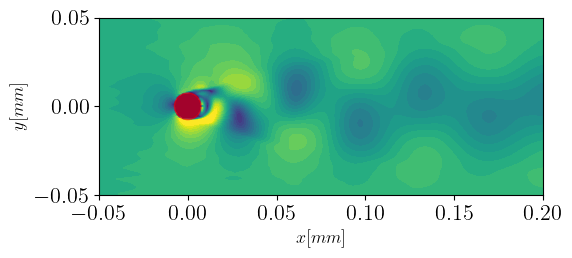

Image exported


<Figure size 640x480 with 0 Axes>

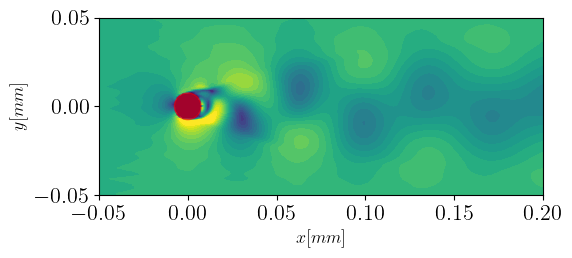

Image exported


<Figure size 640x480 with 0 Axes>

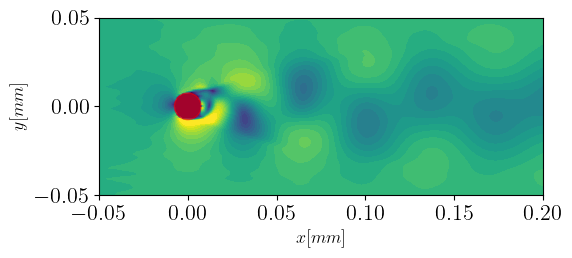

Image exported


<Figure size 640x480 with 0 Axes>

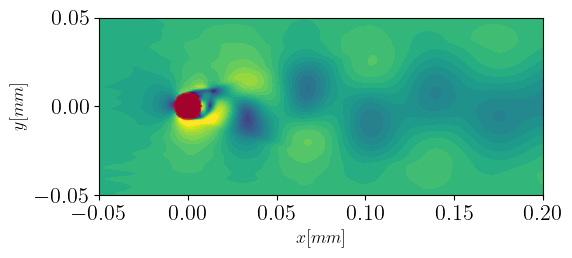

Image exported


<Figure size 640x480 with 0 Axes>

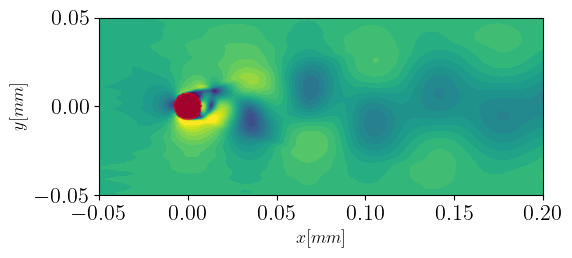

Image exported


<Figure size 640x480 with 0 Axes>

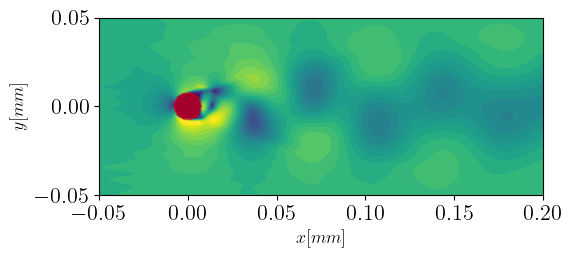

Image exported


<Figure size 640x480 with 0 Axes>

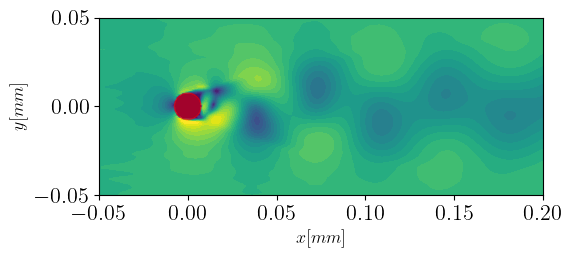

Image exported


<Figure size 640x480 with 0 Axes>

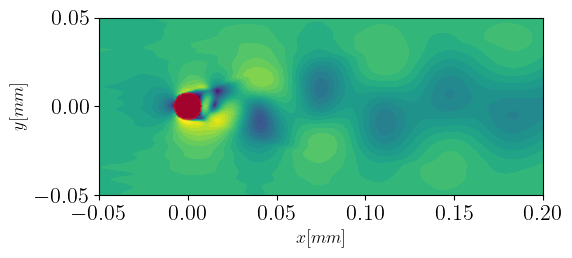

Image exported


<Figure size 640x480 with 0 Axes>

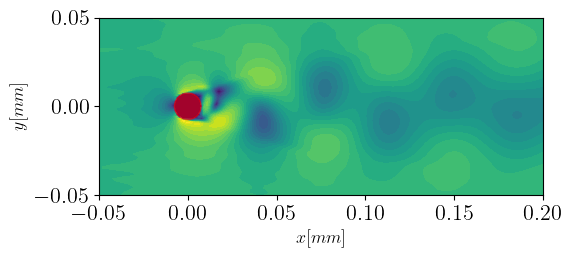

Image exported


<Figure size 640x480 with 0 Axes>

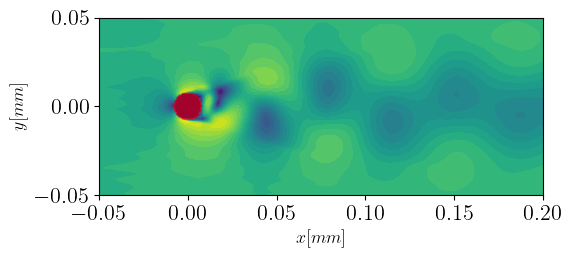

Image exported


<Figure size 640x480 with 0 Axes>

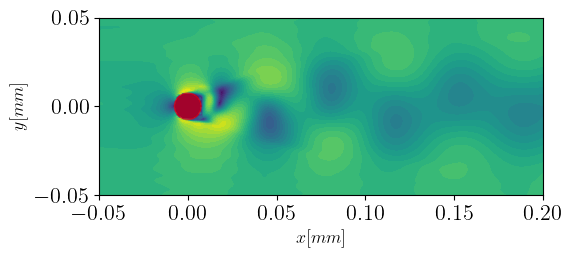

Image exported


<Figure size 640x480 with 0 Axes>

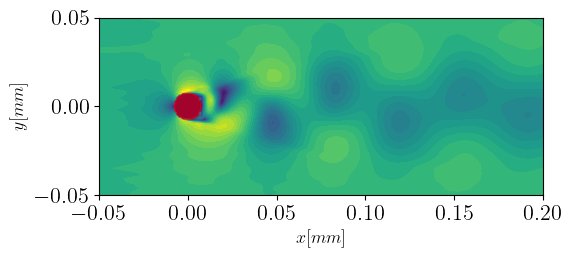

Image exported


<Figure size 640x480 with 0 Axes>

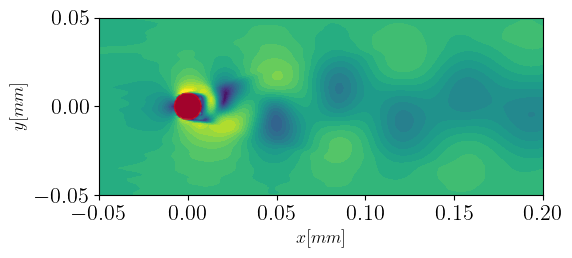

Image exported


<Figure size 640x480 with 0 Axes>

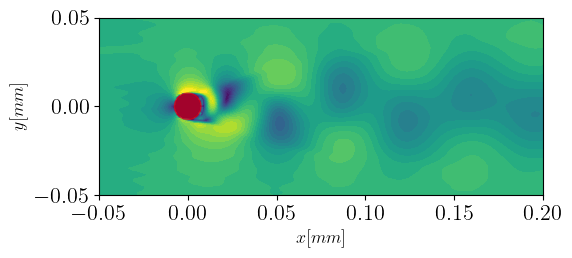

Image exported


<Figure size 640x480 with 0 Axes>

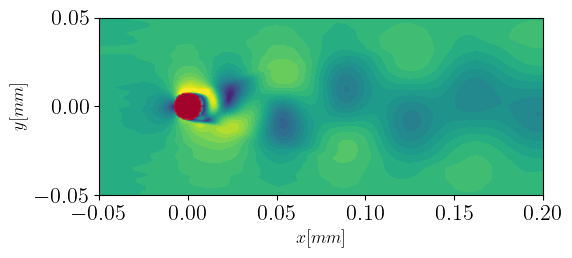

Image exported


<Figure size 640x480 with 0 Axes>

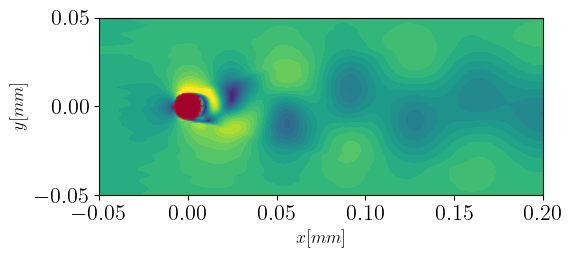

Image exported


<Figure size 640x480 with 0 Axes>

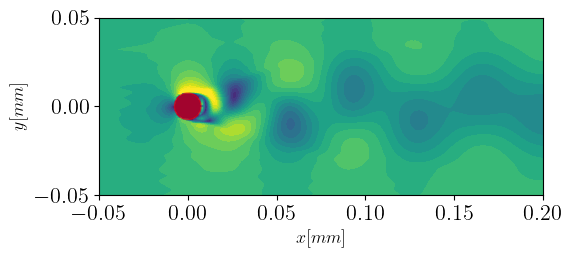

Image exported


<Figure size 640x480 with 0 Axes>

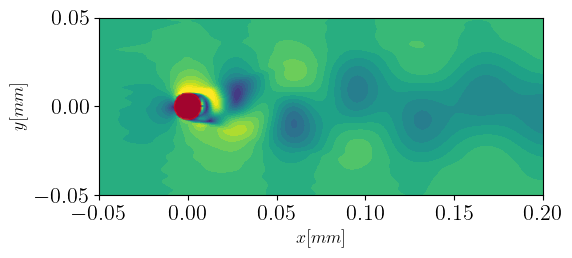

Image exported


<Figure size 640x480 with 0 Axes>

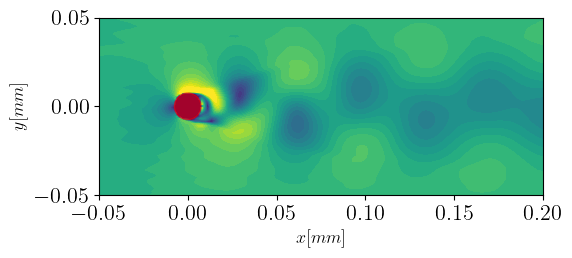

Image exported


<Figure size 640x480 with 0 Axes>

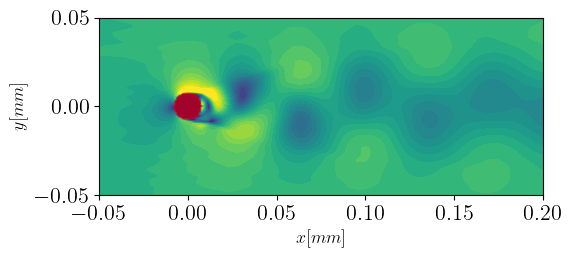

Image exported


<Figure size 640x480 with 0 Axes>

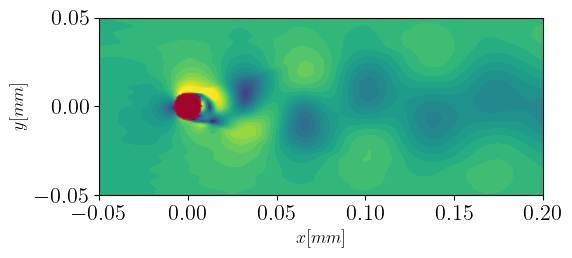

Image exported


<Figure size 640x480 with 0 Axes>

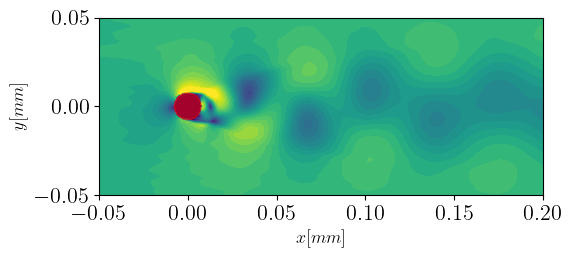

Image exported


<Figure size 640x480 with 0 Axes>

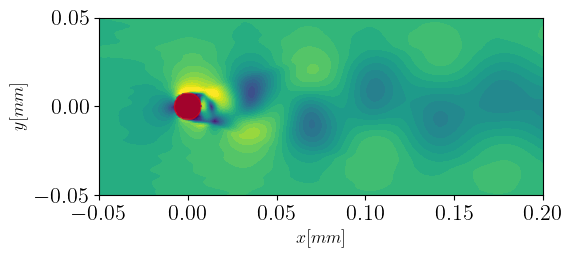

Image exported


<Figure size 640x480 with 0 Axes>

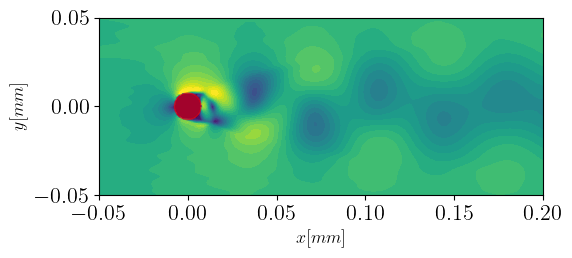

Image exported


<Figure size 640x480 with 0 Axes>

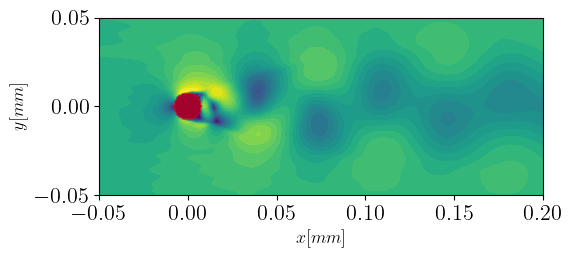

Image exported


<Figure size 640x480 with 0 Axes>

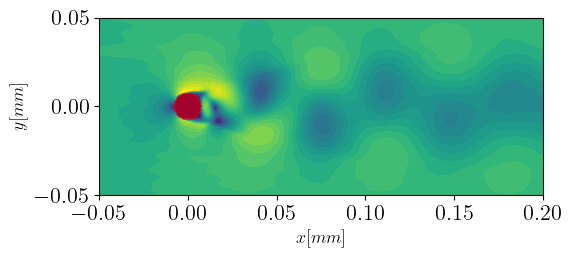

Image exported


<Figure size 640x480 with 0 Axes>

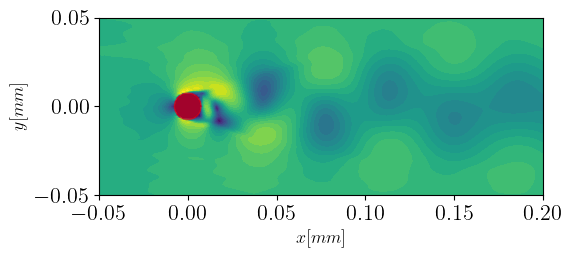

Image exported


<Figure size 640x480 with 0 Axes>

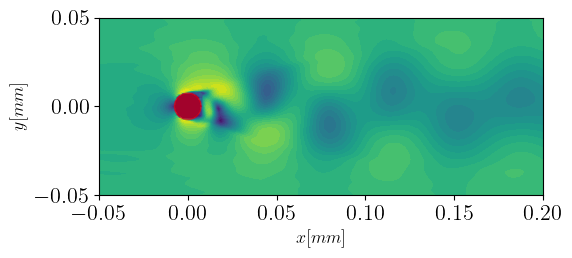

Image exported


<Figure size 640x480 with 0 Axes>

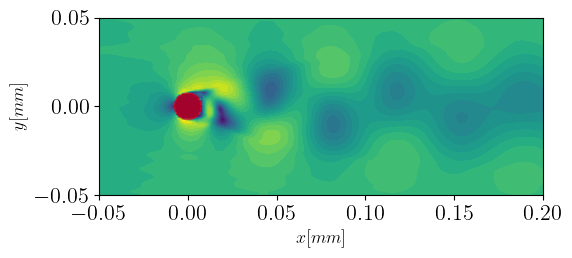

Image exported


<Figure size 640x480 with 0 Axes>

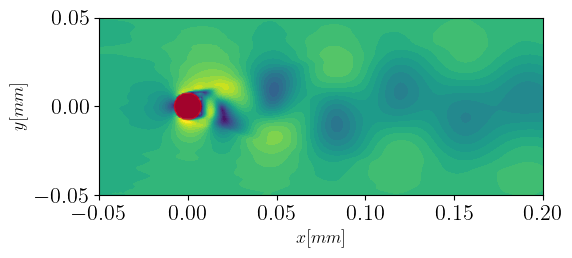

Image exported


<Figure size 640x480 with 0 Axes>

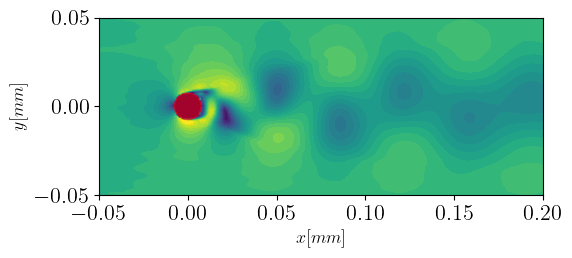

Image exported


<Figure size 640x480 with 0 Axes>

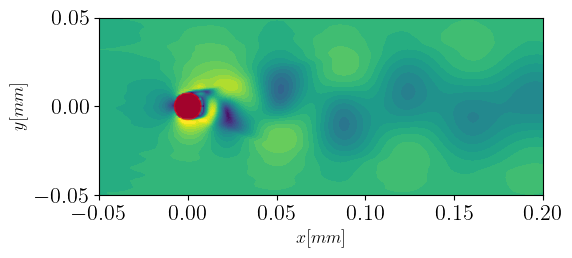

Image exported


<Figure size 640x480 with 0 Axes>

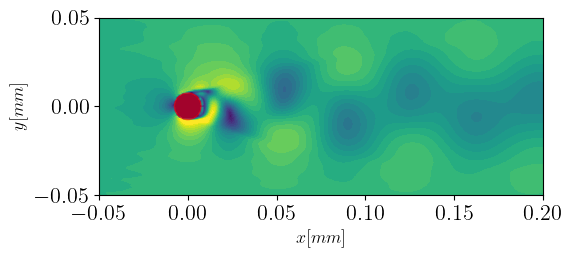

Image exported


<Figure size 640x480 with 0 Axes>

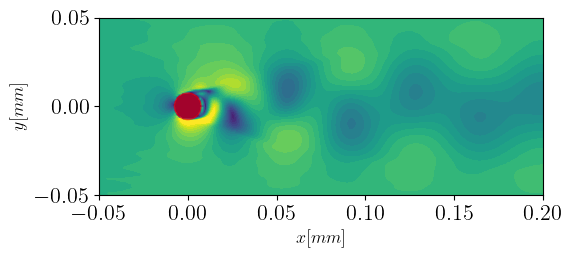

Image exported


<Figure size 640x480 with 0 Axes>

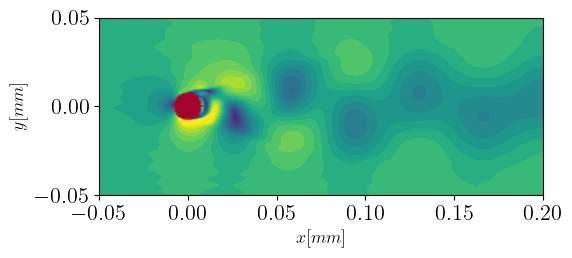

Image exported


<Figure size 640x480 with 0 Axes>

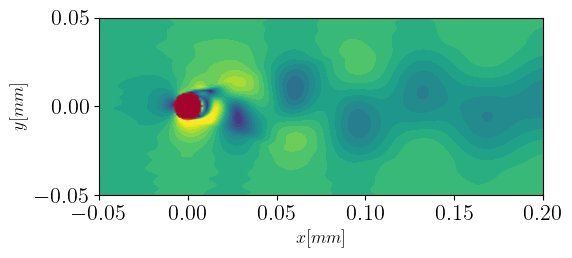

Image exported


<Figure size 640x480 with 0 Axes>

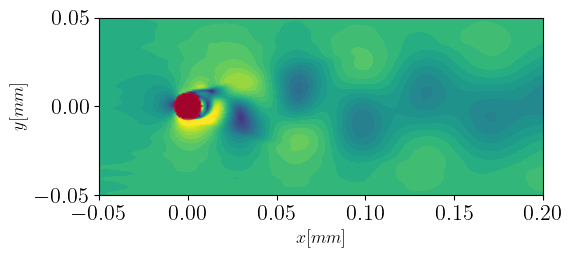

Image exported


<Figure size 640x480 with 0 Axes>

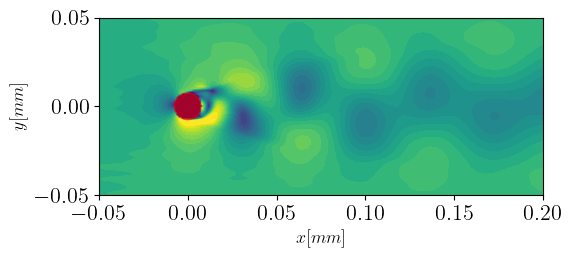

Image exported


<Figure size 640x480 with 0 Axes>

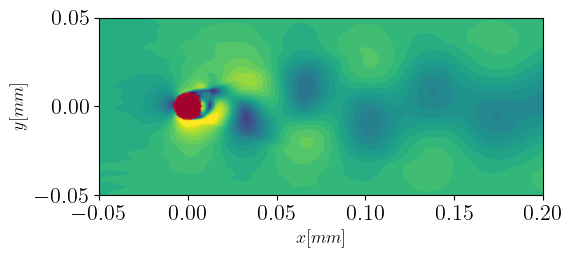

Image exported


<Figure size 640x480 with 0 Axes>

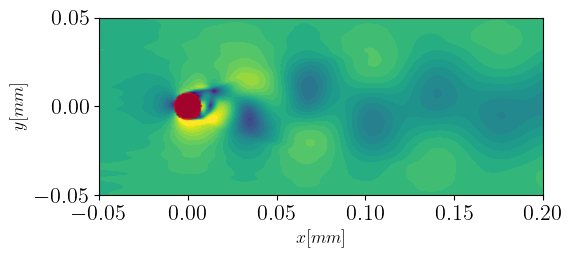

Image exported


<Figure size 640x480 with 0 Axes>

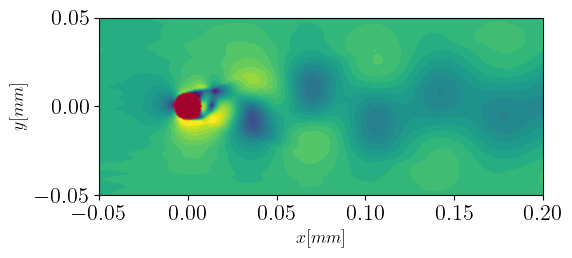

Image exported


<Figure size 640x480 with 0 Axes>

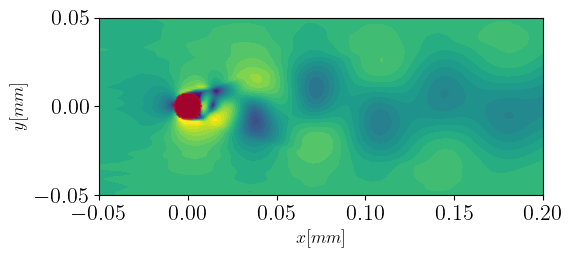

Image exported


<Figure size 640x480 with 0 Axes>

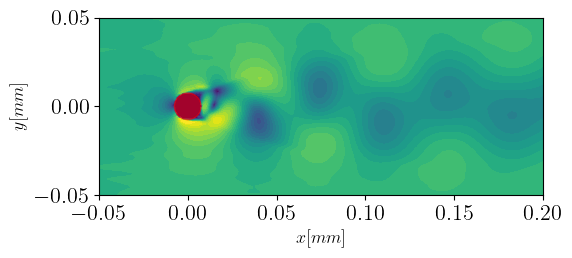

Image exported


<Figure size 640x480 with 0 Axes>

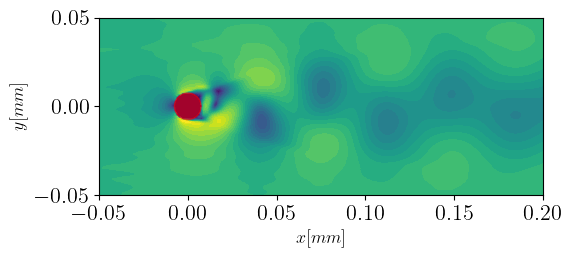

Image exported


<Figure size 640x480 with 0 Axes>

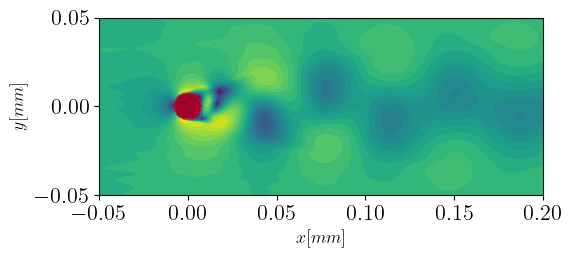

Image exported


<Figure size 640x480 with 0 Axes>

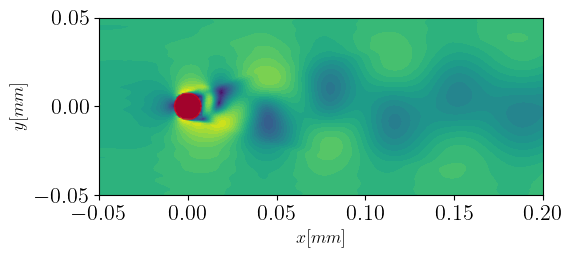

Image exported


<Figure size 640x480 with 0 Axes>

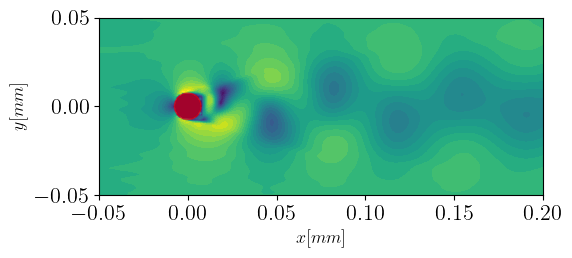

Image exported


<Figure size 640x480 with 0 Axes>

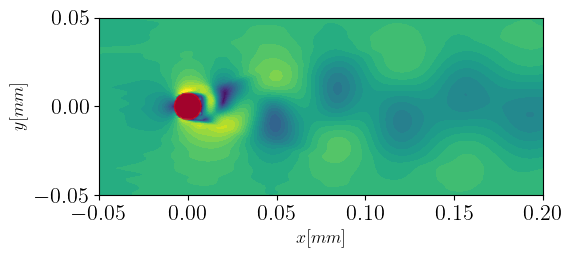

Image exported


<Figure size 640x480 with 0 Axes>

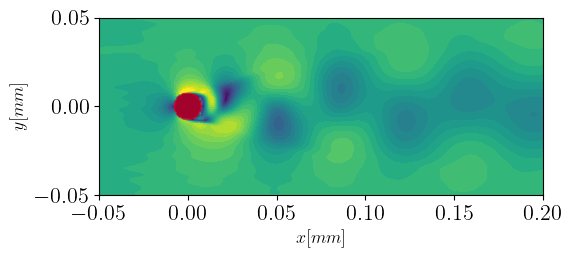

Image exported
Preparing Im 1
Preparing Im 2
Preparing Im 3
Preparing Im 4
Preparing Im 5
Preparing Im 6
Preparing Im 7
Preparing Im 8
Preparing Im 9
Preparing Im 10
Preparing Im 11
Preparing Im 12
Preparing Im 13
Preparing Im 14
Preparing Im 15
Preparing Im 16
Preparing Im 17
Preparing Im 18
Preparing Im 19
Preparing Im 20
Preparing Im 21
Preparing Im 22
Preparing Im 23
Preparing Im 24
Preparing Im 25
Preparing Im 26
Preparing Im 27
Preparing Im 28
Preparing Im 29
Preparing Im 30
Preparing Im 31
Preparing Im 32
Preparing Im 33
Preparing Im 34
Preparing Im 35
Preparing Im 36
Preparing Im 37
Preparing Im 38
Preparing Im 39
Preparing Im 40
Preparing Im 41
Preparing Im 42
Preparing Im 43
Preparing Im 44
Preparing Im 45
Preparing Im 46
Preparing Im 47
Preparing Im 48
Preparing Im 49
Preparing Im 50
Preparing Im 51
Preparing Im 52
Preparing Im 53
Preparing Im 54
Preparing Im 55
Preparing Im 56
Preparing Im 57
Preparing Im 58
Preparing Im 59
Preparing Im 60
Preparing Im 61
Preparing Im 62
Pr

'Gif Created'

<Figure size 640x480 with 0 Axes>

In [9]:
# Here is the approximation with the leading 3 POD modes
R=3
D_P=np.real(np.linalg.multi_dot([Phi_POD[:,0:R],
                                 np.diag(Sigma_POD[0:R]),
                                 Psi_POD[:,0:R].T]) )
Error=np.linalg.norm(m.D-D_P)/np.linalg.norm(m.D)

Name_GIF=FOLDER+os.sep+'Animation_Approximation.gif'   
Animation_2D_CFD_Cyl(Name_GIF,D_P,Xg,Yg,1,100,1)



## Step 2 : Dynamic Mode Decomposition

We perform the DMD using the scipy's sparse solver as svd solver.
The other SVD solvers are 'svd_numpy', 'svd_scipy_sparse', 'svd_sklearn_randomized', 'svd_sklearn_truncated'. Test them. The first is the most accurate but also the most expensive computationally. The third is the fastest, but less accurate. The second is a reasonable compromise. The last lets skitlearn select which solver to use (see https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) 

In [10]:
FOLDER_DMD_RESULTS=FOLDER+os.sep+'DMD_Results_Cylinder_CFD'
if not os.path.exists(FOLDER_DMD_RESULTS):
    os.makedirs(FOLDER_DMD_RESULTS)

Phi_D, Lambda, freqs, a0s = m.compute_DMD_PIP(False, F_S=1000)


SVD of D1 rdy
reduced propagator rdy
 lambdas and freqs rdy
Phi_D rdy
Sigma_D rdy


#### Plot and export the DMD spectra and the first 6 DMD spatial structures

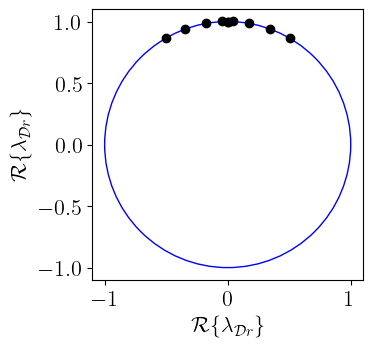

<Figure size 640x480 with 0 Axes>

In [11]:
#%% Plot DMD Spectra in the Circle
fig, ax = plt.subplots(figsize=(4, 4)) 
plt.plot(np.imag(Lambda),np.real(Lambda),'ko')
circle=plt.Circle((0,0),1,color='b', fill=False)
ax.add_patch(circle)
ax.set_aspect('equal')
ax.set_xlabel('$\mathcal{R}\{\lambda_{\mathcal{D}r}\}$',fontsize=16)
ax.set_ylabel('$\mathcal{R}\{\lambda_{\mathcal{D}r}\}$',fontsize=16)
plt.tight_layout()
Name=FOLDER_DMD_RESULTS+os.sep+'lambdas_D.png'
plt.show()
plt.savefig(Name, dpi=300) 

c:\users\mendez\documents\github\modulo\modulo\utils\others.py:218: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((0,0),0.0075,fill=True,color='r',edgecolor='k',alpha=0.5)


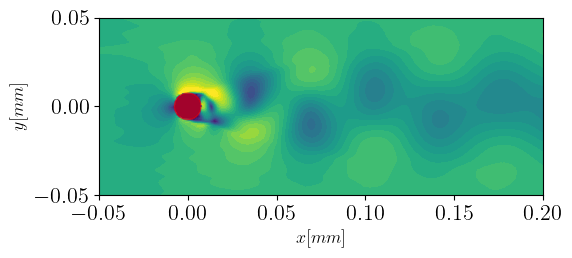

Image exported


<Figure size 640x480 with 0 Axes>

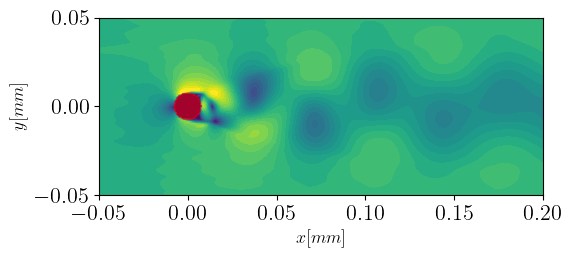

Image exported


<Figure size 640x480 with 0 Axes>

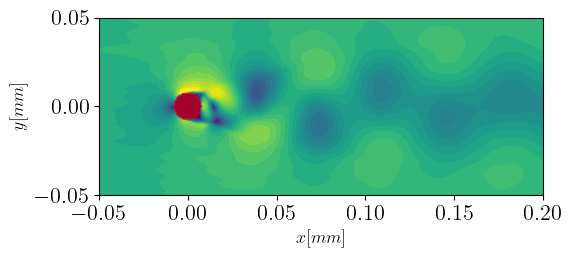

Image exported


<Figure size 640x480 with 0 Axes>

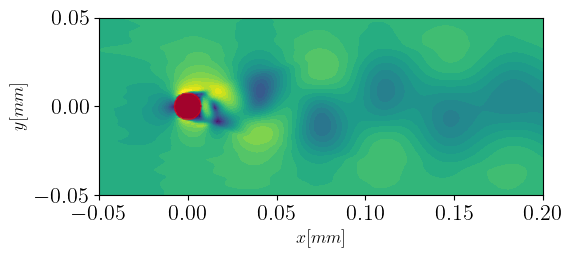

Image exported


<Figure size 640x480 with 0 Axes>

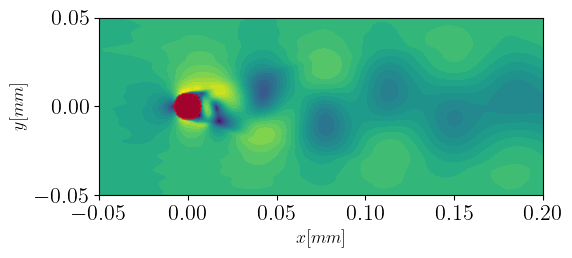

Image exported


<Figure size 640x480 with 0 Axes>

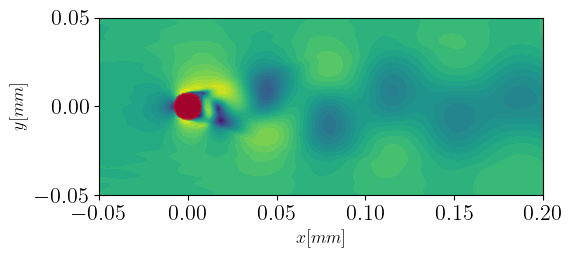

Image exported


<Figure size 640x480 with 0 Axes>

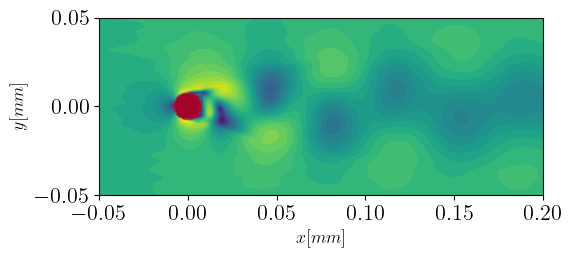

Image exported


<Figure size 640x480 with 0 Axes>

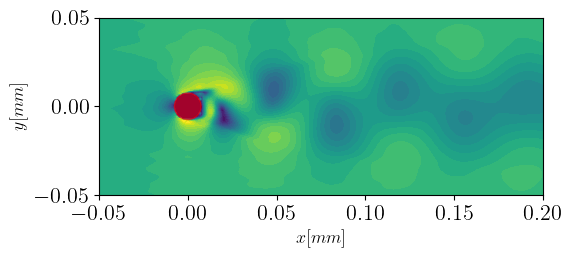

Image exported


<Figure size 640x480 with 0 Axes>

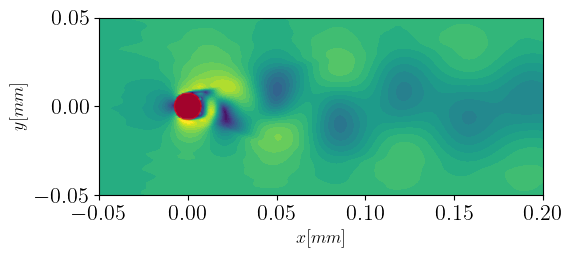

Image exported


<Figure size 640x480 with 0 Axes>

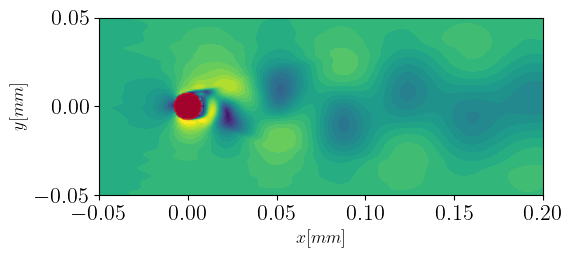

Image exported


<Figure size 640x480 with 0 Axes>

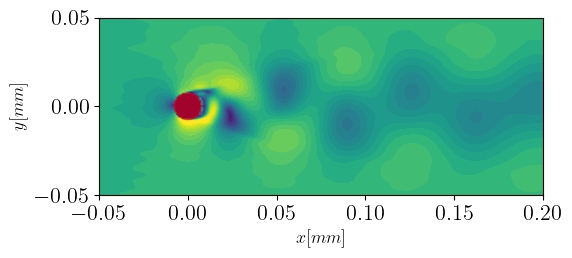

Image exported


<Figure size 640x480 with 0 Axes>

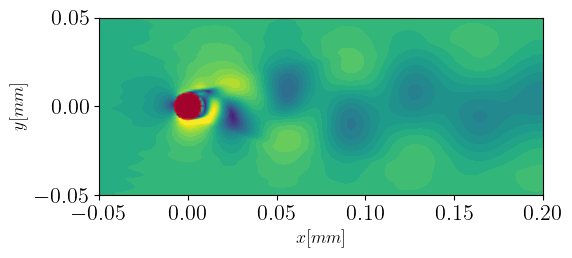

Image exported


<Figure size 640x480 with 0 Axes>

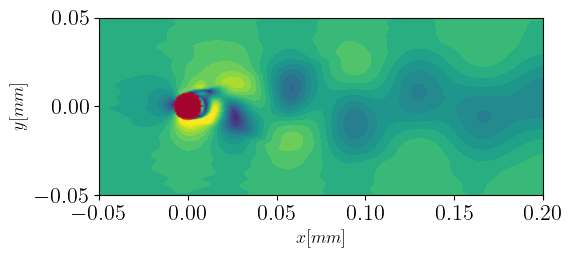

Image exported


<Figure size 640x480 with 0 Axes>

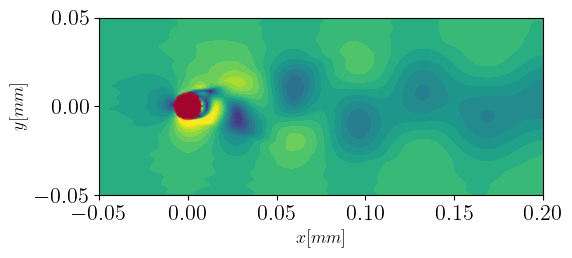

Image exported


<Figure size 640x480 with 0 Axes>

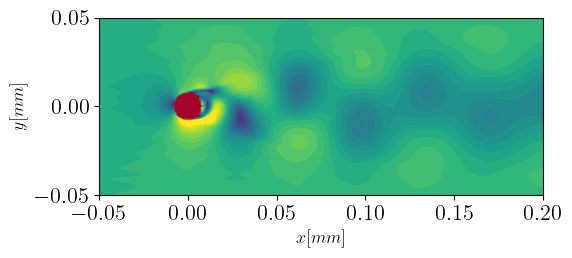

Image exported


<Figure size 640x480 with 0 Axes>

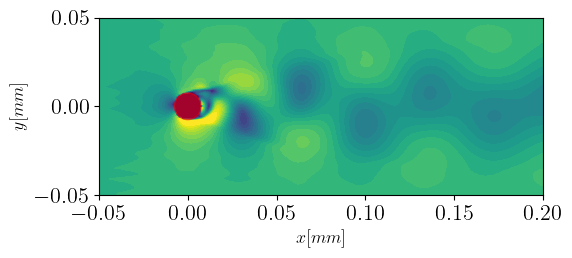

Image exported


<Figure size 640x480 with 0 Axes>

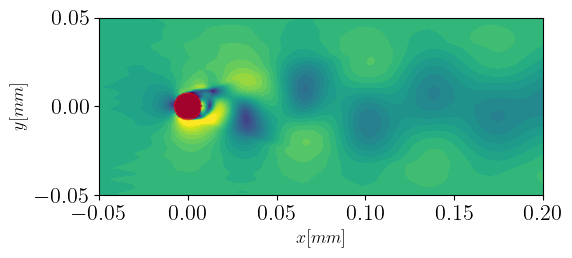

Image exported


<Figure size 640x480 with 0 Axes>

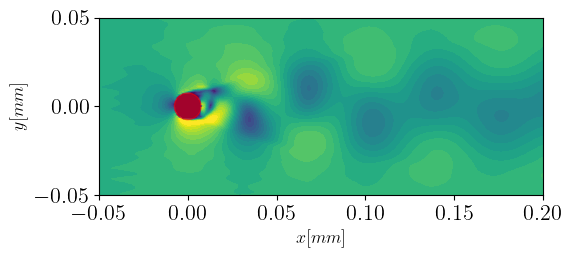

Image exported


<Figure size 640x480 with 0 Axes>

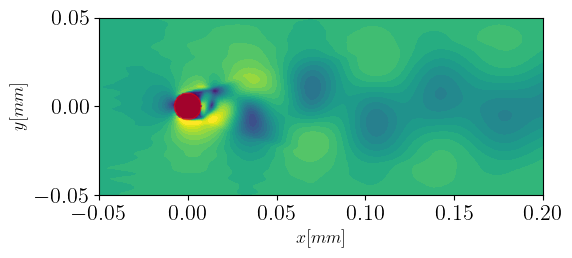

Image exported


<Figure size 640x480 with 0 Axes>

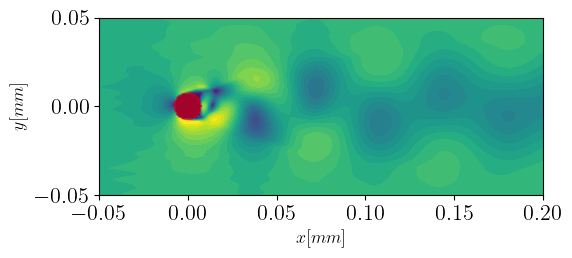

Image exported


<Figure size 640x480 with 0 Axes>

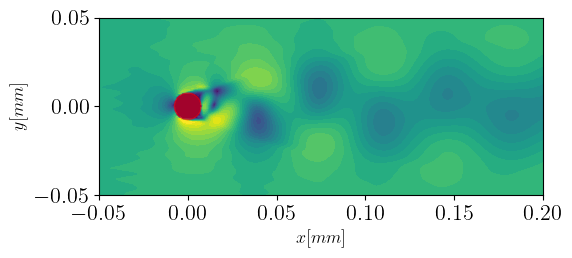

Image exported


<Figure size 640x480 with 0 Axes>

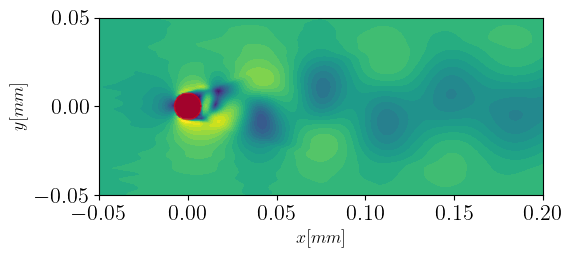

Image exported


<Figure size 640x480 with 0 Axes>

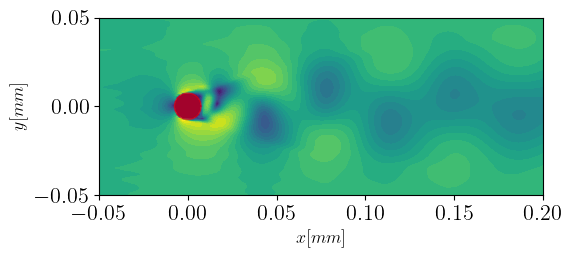

Image exported


<Figure size 640x480 with 0 Axes>

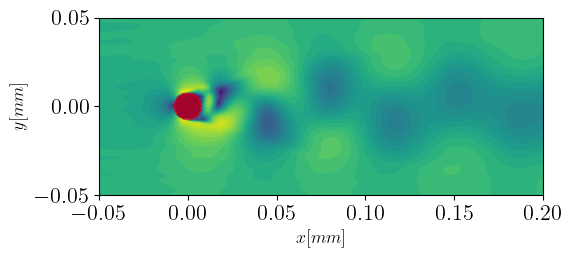

Image exported


<Figure size 640x480 with 0 Axes>

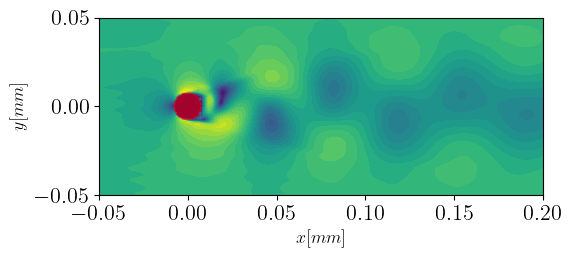

Image exported


<Figure size 640x480 with 0 Axes>

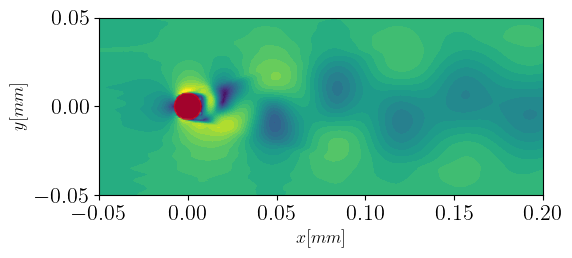

Image exported


<Figure size 640x480 with 0 Axes>

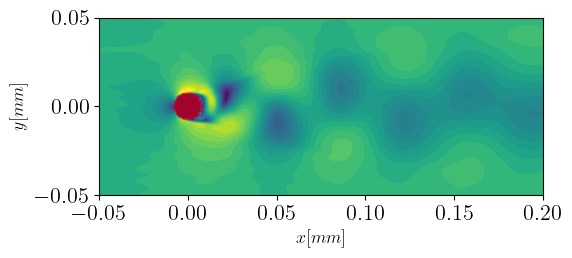

Image exported


<Figure size 640x480 with 0 Axes>

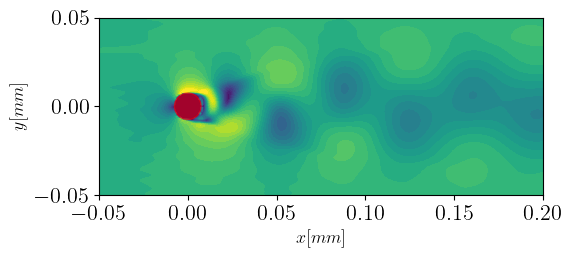

Image exported


<Figure size 640x480 with 0 Axes>

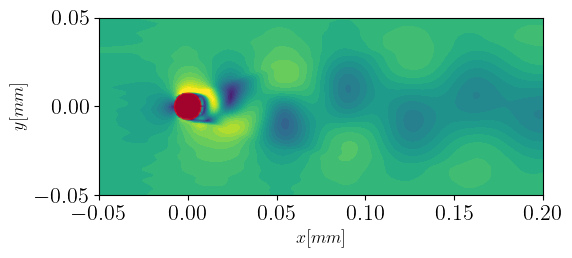

Image exported


<Figure size 640x480 with 0 Axes>

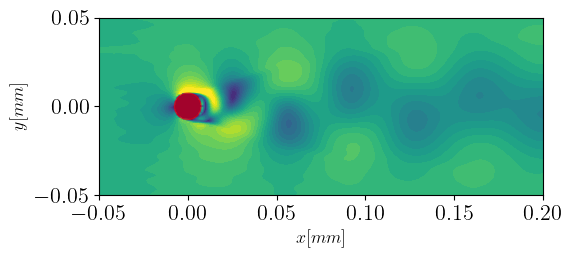

Image exported


<Figure size 640x480 with 0 Axes>

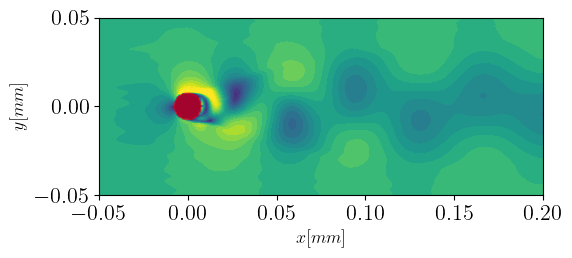

Image exported


<Figure size 640x480 with 0 Axes>

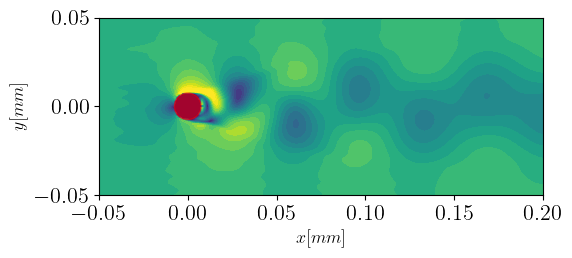

Image exported


<Figure size 640x480 with 0 Axes>

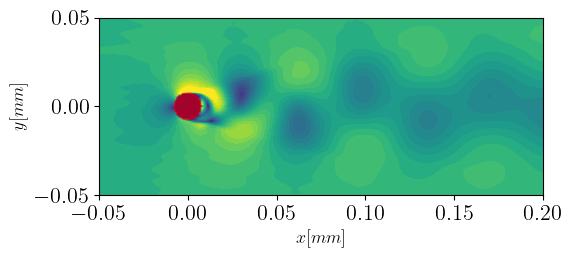

Image exported


<Figure size 640x480 with 0 Axes>

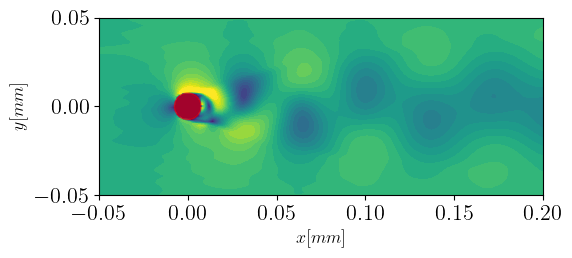

Image exported


<Figure size 640x480 with 0 Axes>

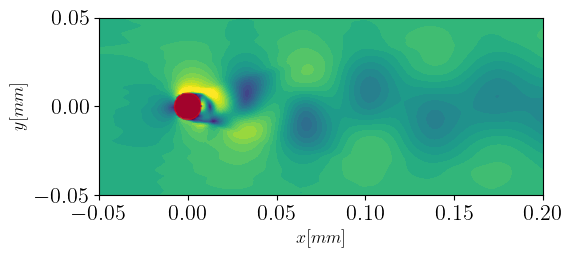

Image exported


<Figure size 640x480 with 0 Axes>

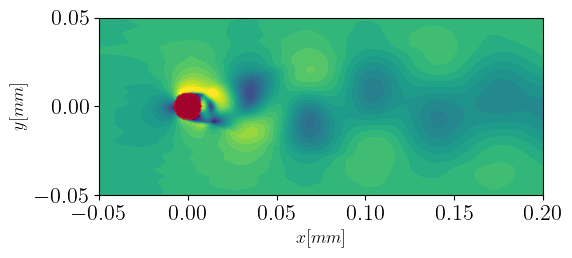

Image exported


<Figure size 640x480 with 0 Axes>

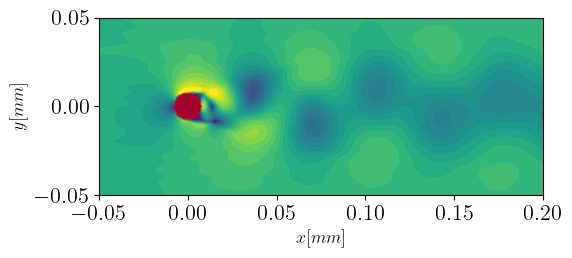

Image exported


<Figure size 640x480 with 0 Axes>

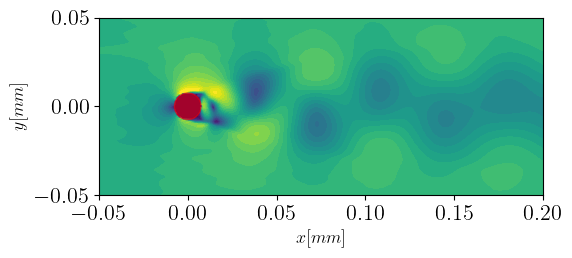

Image exported


<Figure size 640x480 with 0 Axes>

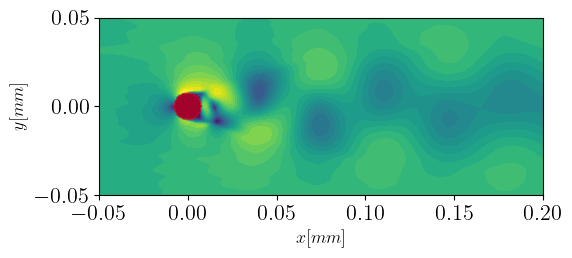

Image exported


<Figure size 640x480 with 0 Axes>

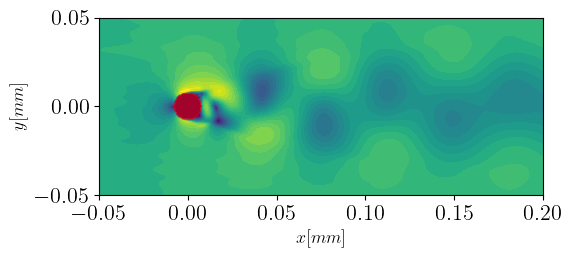

Image exported


<Figure size 640x480 with 0 Axes>

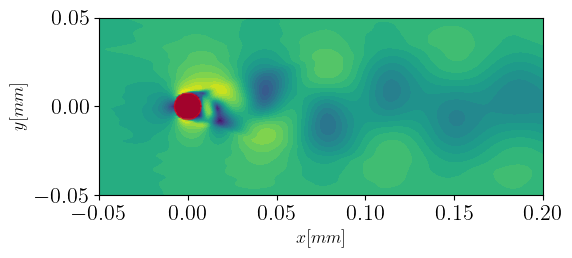

Image exported


<Figure size 640x480 with 0 Axes>

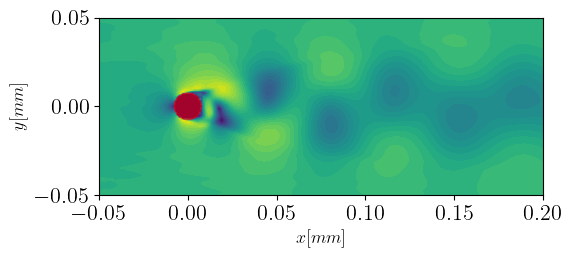

Image exported


<Figure size 640x480 with 0 Axes>

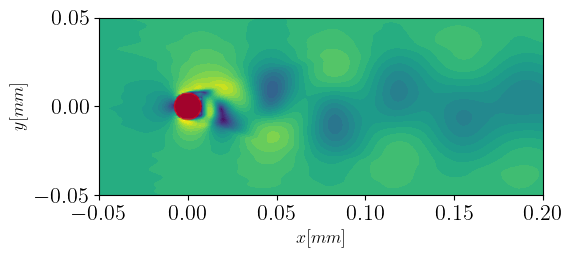

Image exported


<Figure size 640x480 with 0 Axes>

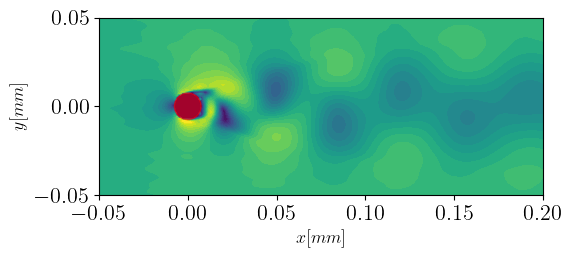

Image exported


<Figure size 640x480 with 0 Axes>

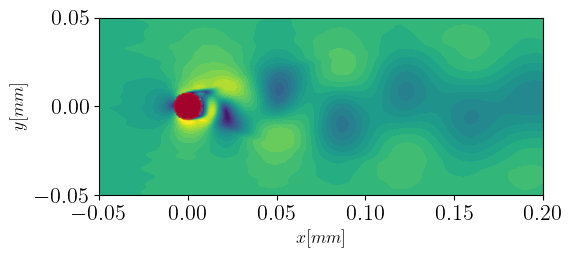

Image exported


<Figure size 640x480 with 0 Axes>

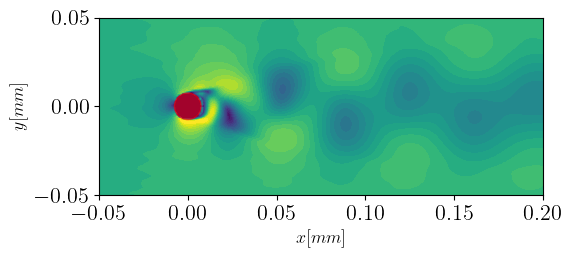

Image exported


<Figure size 640x480 with 0 Axes>

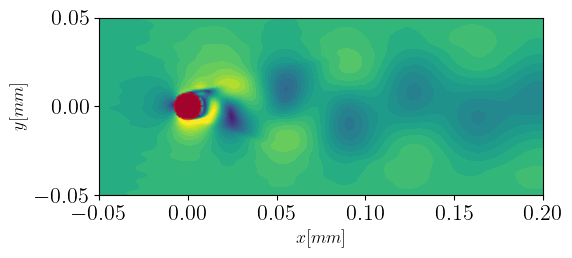

Image exported


<Figure size 640x480 with 0 Axes>

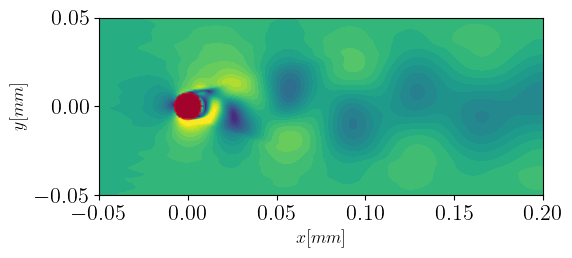

Image exported


<Figure size 640x480 with 0 Axes>

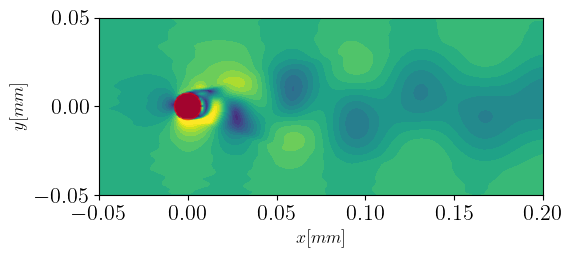

Image exported


<Figure size 640x480 with 0 Axes>

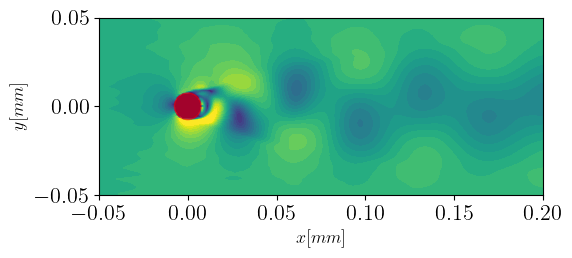

Image exported


<Figure size 640x480 with 0 Axes>

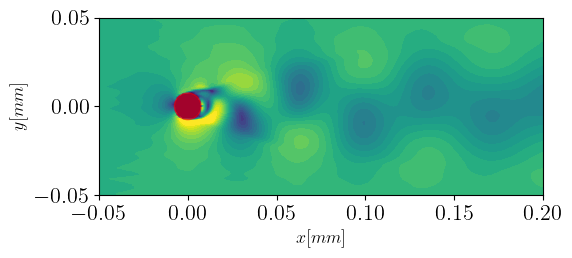

Image exported


<Figure size 640x480 with 0 Axes>

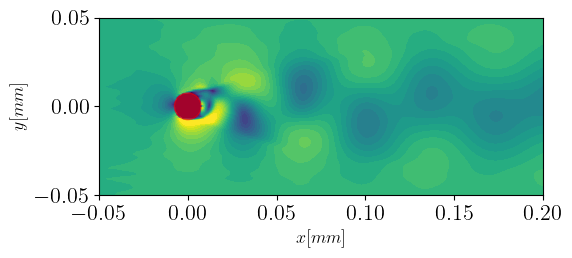

Image exported


<Figure size 640x480 with 0 Axes>

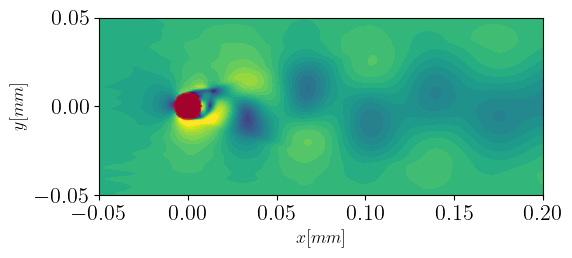

Image exported


<Figure size 640x480 with 0 Axes>

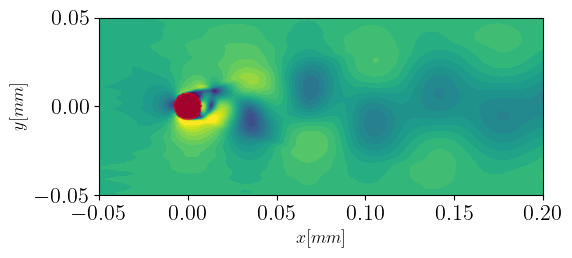

Image exported


<Figure size 640x480 with 0 Axes>

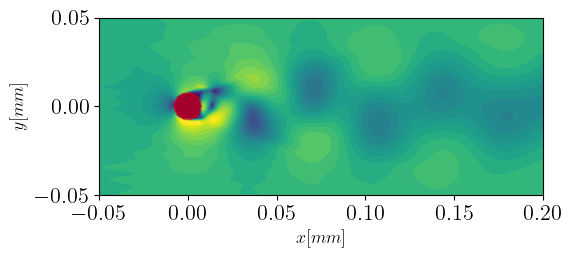

Image exported


<Figure size 640x480 with 0 Axes>

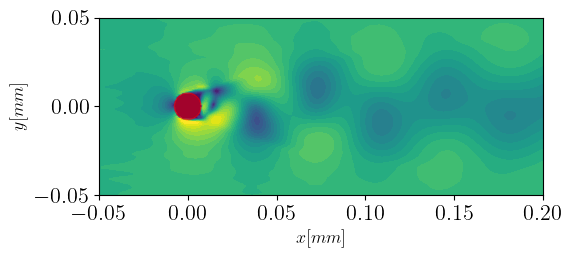

Image exported


<Figure size 640x480 with 0 Axes>

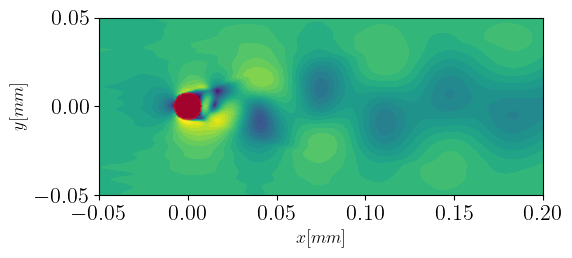

Image exported


<Figure size 640x480 with 0 Axes>

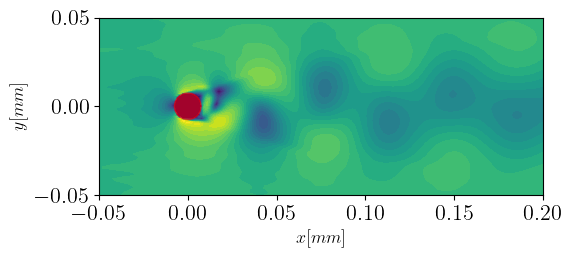

Image exported


<Figure size 640x480 with 0 Axes>

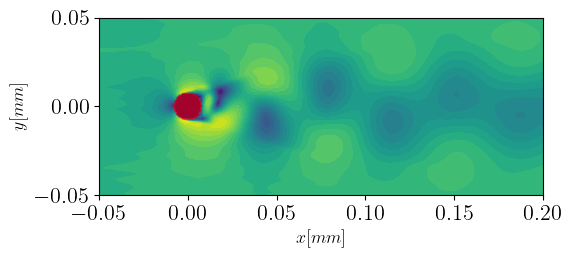

Image exported


<Figure size 640x480 with 0 Axes>

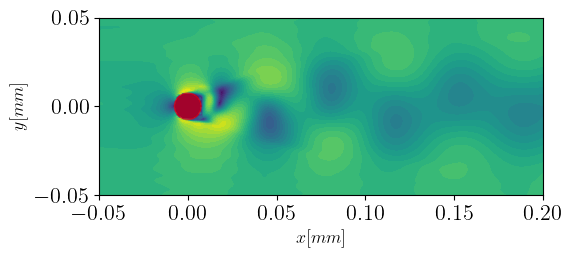

Image exported


<Figure size 640x480 with 0 Axes>

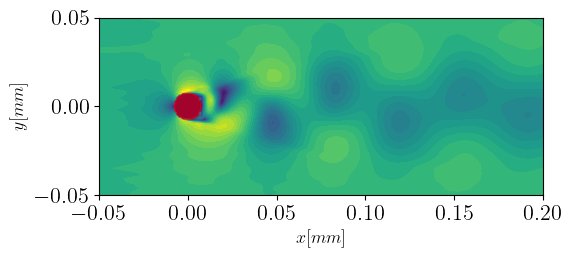

Image exported


<Figure size 640x480 with 0 Axes>

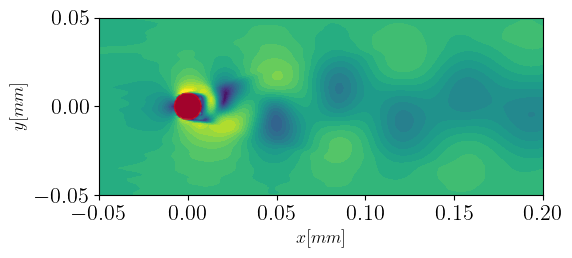

Image exported


<Figure size 640x480 with 0 Axes>

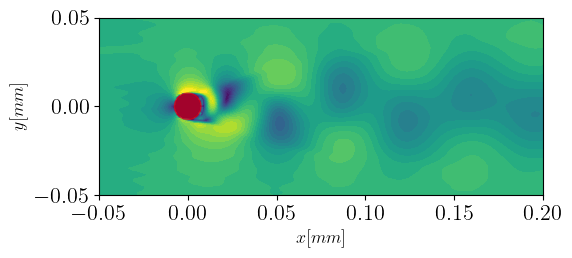

Image exported


<Figure size 640x480 with 0 Axes>

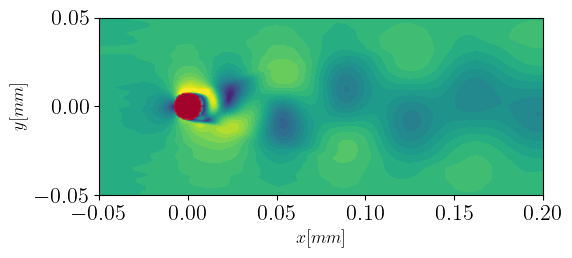

Image exported


<Figure size 640x480 with 0 Axes>

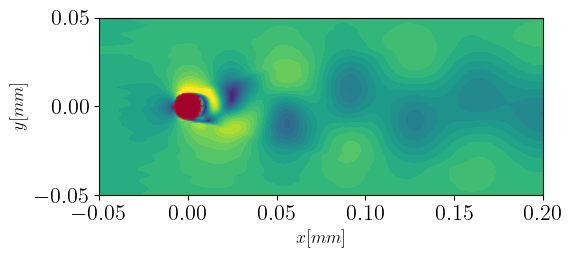

Image exported


<Figure size 640x480 with 0 Axes>

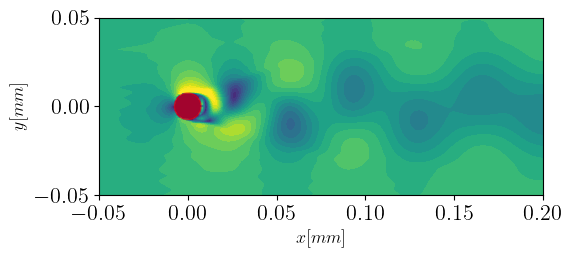

Image exported


<Figure size 640x480 with 0 Axes>

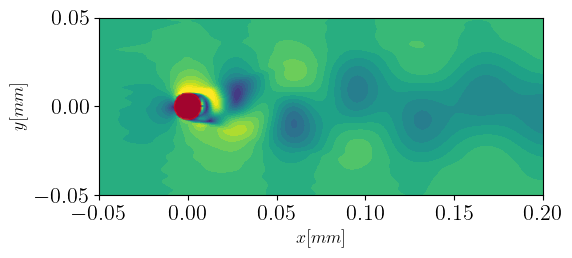

Image exported


<Figure size 640x480 with 0 Axes>

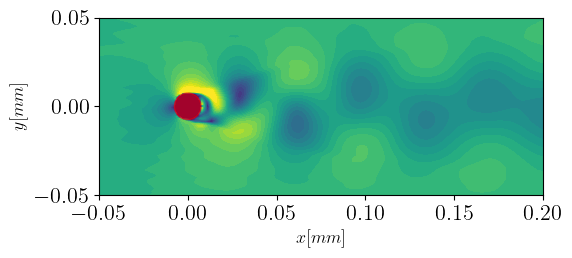

Image exported


<Figure size 640x480 with 0 Axes>

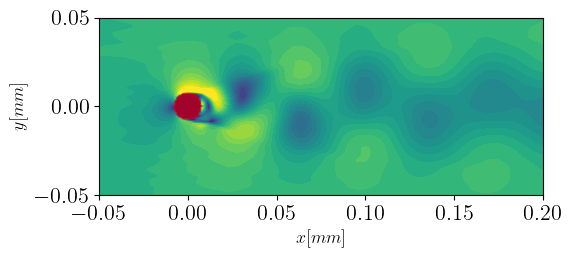

Image exported


<Figure size 640x480 with 0 Axes>

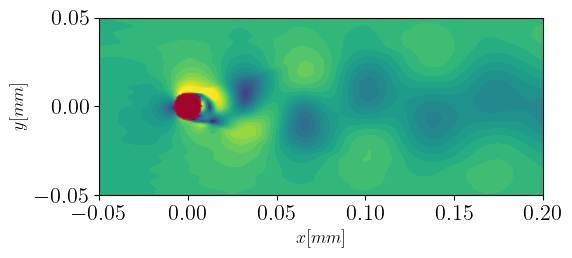

Image exported


<Figure size 640x480 with 0 Axes>

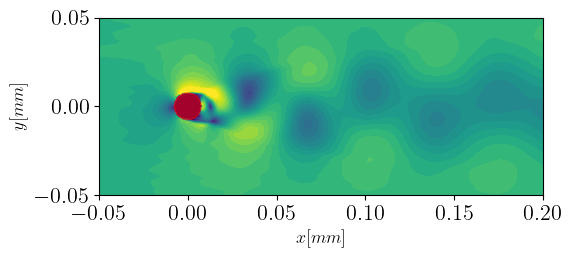

Image exported


<Figure size 640x480 with 0 Axes>

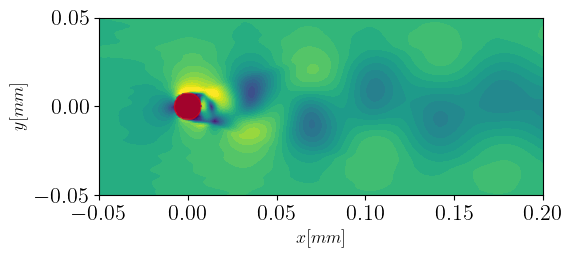

Image exported


<Figure size 640x480 with 0 Axes>

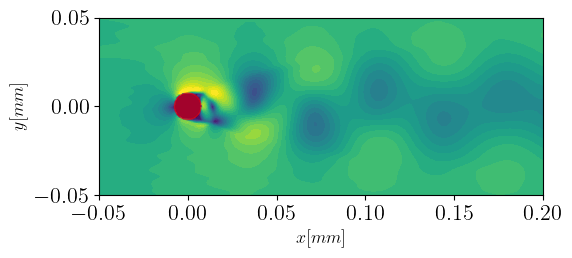

Image exported


<Figure size 640x480 with 0 Axes>

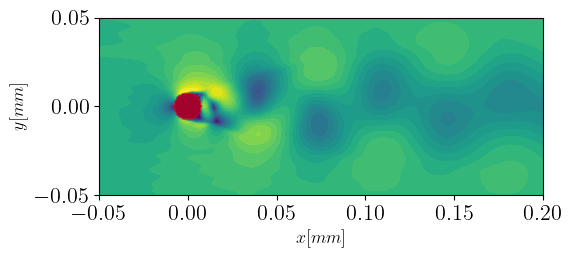

Image exported


<Figure size 640x480 with 0 Axes>

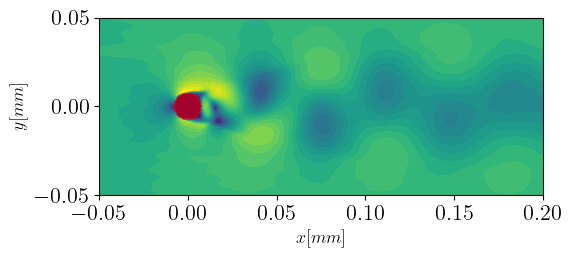

Image exported


<Figure size 640x480 with 0 Axes>

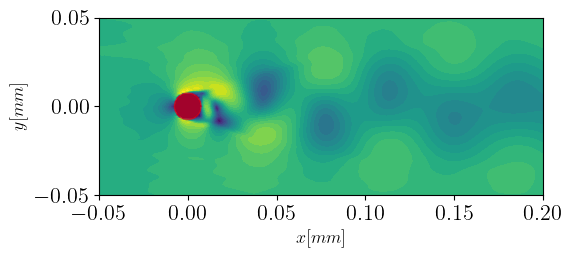

Image exported


<Figure size 640x480 with 0 Axes>

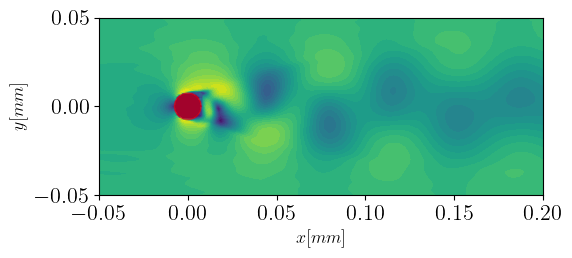

Image exported


<Figure size 640x480 with 0 Axes>

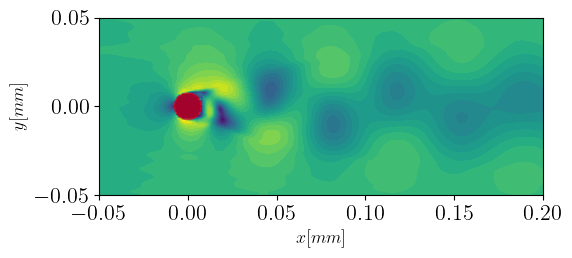

Image exported


<Figure size 640x480 with 0 Axes>

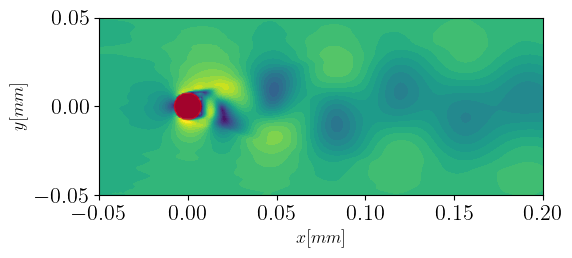

Image exported


<Figure size 640x480 with 0 Axes>

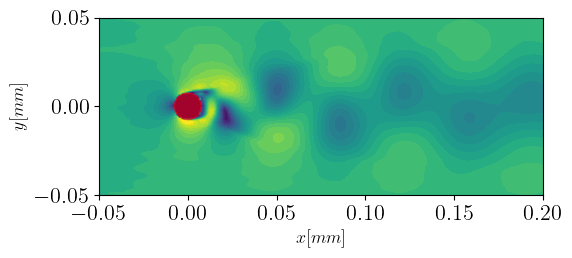

Image exported


<Figure size 640x480 with 0 Axes>

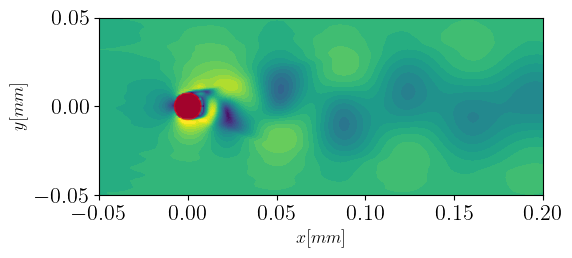

Image exported


<Figure size 640x480 with 0 Axes>

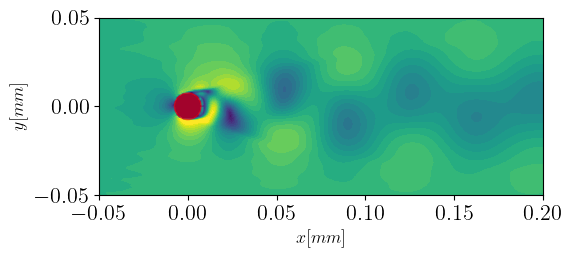

Image exported


<Figure size 640x480 with 0 Axes>

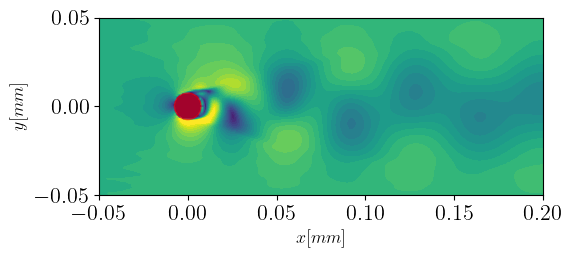

Image exported


<Figure size 640x480 with 0 Axes>

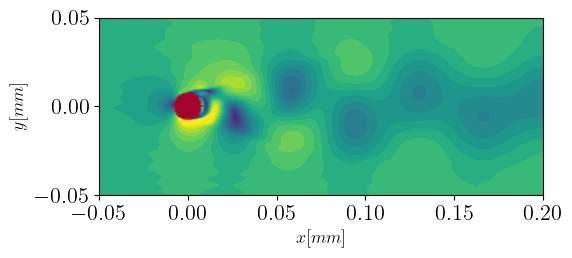

Image exported


<Figure size 640x480 with 0 Axes>

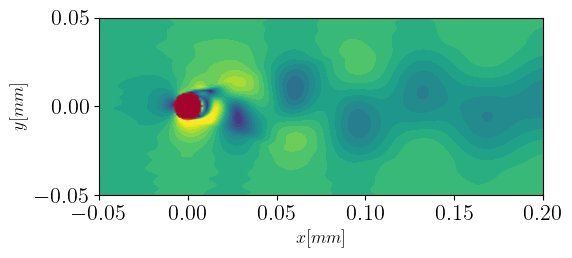

Image exported


<Figure size 640x480 with 0 Axes>

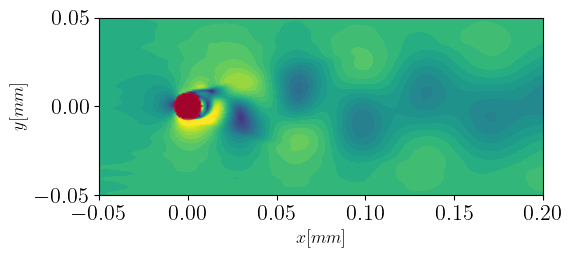

Image exported


<Figure size 640x480 with 0 Axes>

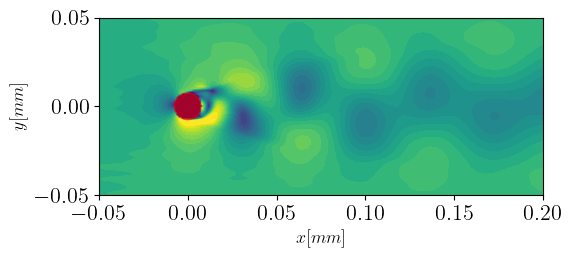

Image exported


<Figure size 640x480 with 0 Axes>

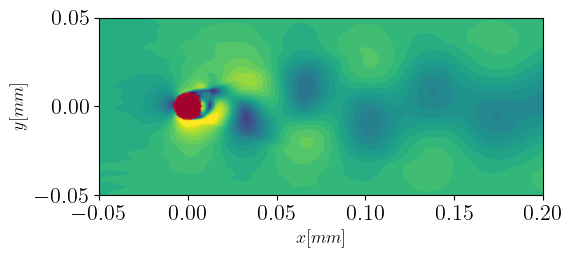

Image exported


<Figure size 640x480 with 0 Axes>

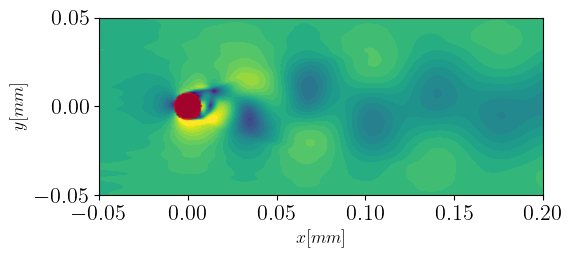

Image exported


<Figure size 640x480 with 0 Axes>

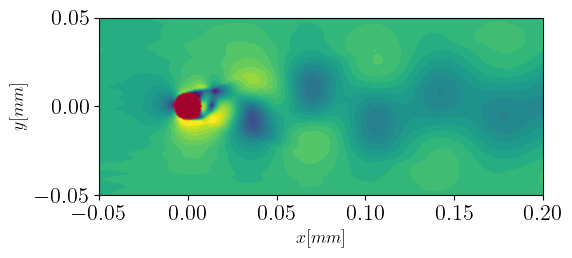

Image exported


<Figure size 640x480 with 0 Axes>

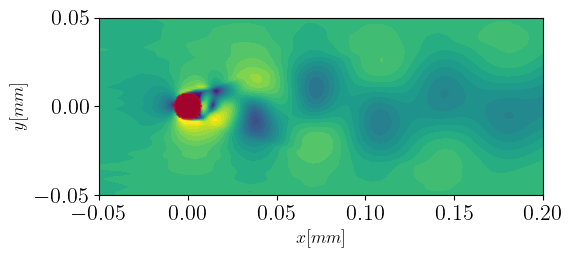

Image exported


<Figure size 640x480 with 0 Axes>

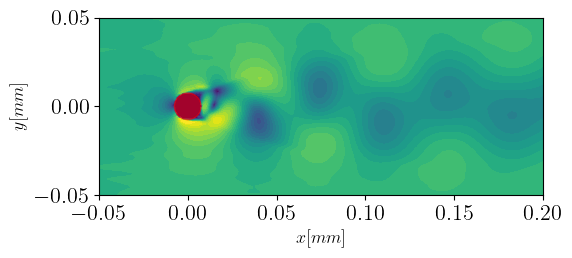

Image exported


<Figure size 640x480 with 0 Axes>

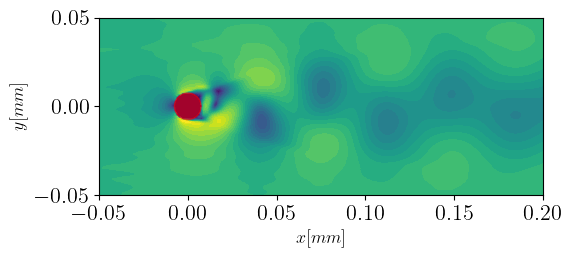

Image exported


<Figure size 640x480 with 0 Axes>

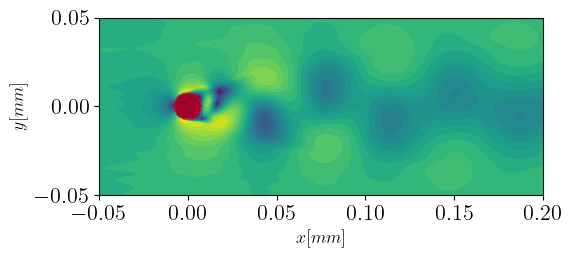

Image exported


<Figure size 640x480 with 0 Axes>

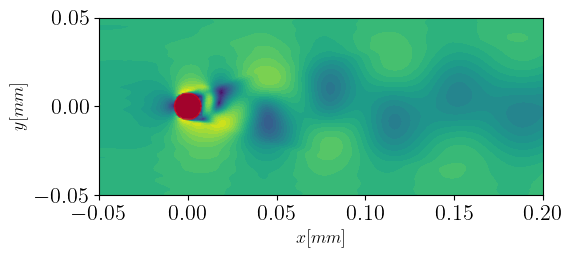

Image exported


<Figure size 640x480 with 0 Axes>

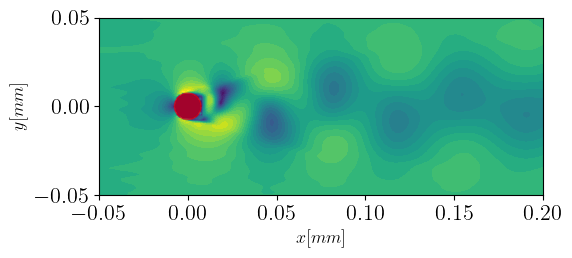

Image exported


<Figure size 640x480 with 0 Axes>

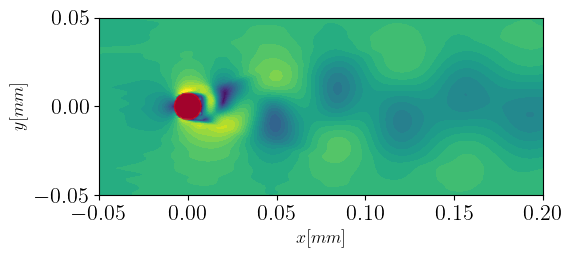

Image exported


<Figure size 640x480 with 0 Axes>

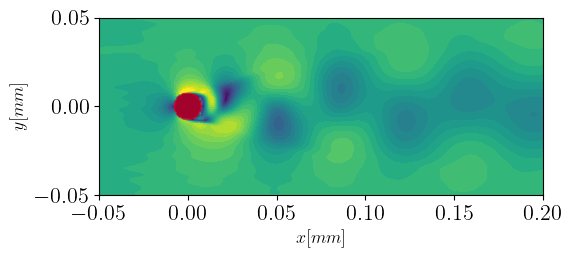

Image exported
Preparing Im 1
Preparing Im 2
Preparing Im 3
Preparing Im 4
Preparing Im 5
Preparing Im 6
Preparing Im 7
Preparing Im 8
Preparing Im 9
Preparing Im 10
Preparing Im 11
Preparing Im 12
Preparing Im 13
Preparing Im 14
Preparing Im 15
Preparing Im 16
Preparing Im 17
Preparing Im 18
Preparing Im 19
Preparing Im 20
Preparing Im 21
Preparing Im 22
Preparing Im 23
Preparing Im 24
Preparing Im 25
Preparing Im 26
Preparing Im 27
Preparing Im 28
Preparing Im 29
Preparing Im 30
Preparing Im 31
Preparing Im 32
Preparing Im 33
Preparing Im 34
Preparing Im 35
Preparing Im 36
Preparing Im 37
Preparing Im 38
Preparing Im 39
Preparing Im 40
Preparing Im 41
Preparing Im 42
Preparing Im 43
Preparing Im 44
Preparing Im 45
Preparing Im 46
Preparing Im 47
Preparing Im 48
Preparing Im 49
Preparing Im 50
Preparing Im 51
Preparing Im 52
Preparing Im 53
Preparing Im 54
Preparing Im 55
Preparing Im 56
Preparing Im 57
Preparing Im 58
Preparing Im 59
Preparing Im 60
Preparing Im 61
Preparing Im 62
Pr

'Gif Created'

<Figure size 640x480 with 0 Axes>

In [12]:
# Here is the approximation with the leading 3 POD modes
R=3
D_P=np.real(np.linalg.multi_dot([Phi_POD[:,0:R],
                                 np.diag(Sigma_POD[0:R]),
                                 Psi_POD[:,0:R].T]) )
Error=np.linalg.norm(m.D-D_P)/np.linalg.norm(m.D)

# Here is the animation of the approximated fields
Name_GIF=FOLDER+os.sep+'Animation_Approximation.gif'   
Animation_2D_CFD_Cyl(Name_GIF,D_P,Xg,Yg,1,100,1)